# **DS plus. Выпускной проект. Предсказание температуры расплава**

**Заказчик** металлургический комбинат «Стальная птица».

**Цель работы** оптимизация производственных расходов за счёт уменьшения потребления электроэнергии на этапе обработки стали.

**Поставленная задача** построить модель предсказания температуры сплава для моделирования технологического процесса.

**Дано** семь таблиц, в которых столбец `'key'` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `'key'`: они соответствуют разным итерациям обработки:
1. *steel.data_arc* — данные об электродах;
    - `'key'` — номер партии;
    - `'BeginHeat'` — время начала нагрева;
    - `'EndHeat'` — время окончания нагрева;
    - `'ActivePower'` — значение активной мощности;
    - `'ReactivePower'` — значение реактивной мощности.
2. *steel.data_bulk* — данные об объёме сыпучих материалов;
    - `'key'` — номер партии;
    - `'Bulk1 … Bulk15'` — объём подаваемого материала.
3. *steel.data_bulk_time* — данные о времени подачи сыпучих материалов;
    - `'key'` — номер партии;
    - `'Bulk1 … Bulk15'` — время подачи материала.
4. *steel.data_gas* — данные о продувке сплава газом;
    - `'key'` — номер партии;
    - `'gas'` — объём подаваемого газа.
5. *steel.data_temp* — данные об измерениях температуры;
    - `'key'` — номер партии;
    - `'MesaureTime'` — время замера;
    - `'Temperature'` — значение температуры.
6. *steel.data_wire* — данные об объёме проволочных материалов;
    - `'key'` — номер партии;
    - `'Wire1 … Wire15'` — объём подаваемых проволочных материалов.
7. *steel.data_wire_time* — данные о времени подачи проволочных материалов.
    - `'key'` — номер партии;
    - `'Wire1 … Wire15'` — время подачи проволочных материалов.

**План работ:**
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Обучение модели
4. Тестирование модели
5. Написание выводов по работе

In [2]:
# Настройка широкоформатного режима Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st
import shap
import phik
import warnings
import optuna
import xgboost as xgb
import lightgbm as lgb

import torch
import torch.nn as nn
import torch.utils.data as data_utils

from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures
from sqlalchemy import create_engine
from catboost import CatBoostRegressor
from lineartree import LinearTreeRegressor, LinearBoostRegressor

from sklearn.dummy import DummyRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from optuna import TrialPruned
from optuna.samplers import TPESampler
from optuna.pruners import ThresholdPruner, SuccessiveHalvingPruner

RANDOM_STATE = 40324

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')
np.random.seed(RANDOM_STATE)

## **1. Загрузка данных**

In [4]:
# Создание подключения к базе данных
db_config = {
    'user': None,
     'pwd': None,
    'host': None,
    'port': None,
      'db': None,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine_cloud = create_engine(connection_string)

In [5]:
# Выгрузка размеров и состава колонок таблиц
table_names = ['data_arc','data_bulk','data_bulk_time','data_gas','data_temp','data_wire','data_wire_time']
for table_name in table_names: # Пройдемся по каждой таблице
    
    # Запрос для получения размера таблицы
    table_size_query = f"SELECT COUNT(*) FROM steel.{table_name};"
    table_size = pd.read_sql_query(table_size_query, con=engine_cloud)
    
    # Запрос для получения названий колонок
    column_names_query = f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';"
    column_names = pd.read_sql_query(column_names_query, con=engine_cloud)
    
    # Выведем информацию о таблице
    print(f"Таблица: {table_name}")
    print(f"Размер: {table_size.iloc[0, 0]} строк")
    print(f"Названия колонок: {', '.join(column_names['column_name'])}\n")

del table_names, table_size_query, table_size, column_names_query, column_names, table_name

Таблица: data_arc
Размер: 14876 строк
Названия колонок: key, BeginHeat, EndHeat, ActivePower, ReactivePower

Таблица: data_bulk
Размер: 3129 строк
Названия колонок: key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15

Таблица: data_bulk_time
Размер: 3129 строк
Названия колонок: key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15

Таблица: data_gas
Размер: 3239 строк
Названия колонок: key, gas

Таблица: data_temp
Размер: 15907 строк
Названия колонок: key, MesaureTime, Temperature

Таблица: data_wire
Размер: 3081 строк
Названия колонок: key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9

Таблица: data_wire_time
Размер: 3081 строк
Названия колонок: key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9



База данных содержит информацию о семи таблицах, указанных в описании. Размер таблиц колеблется в диапазоне 3081-15907, колонок 2-15. Таблицы data_wire и data_wire_time содержат только 9 колонок, что не соответствует описанию задания, где количество колонок должно быть равно 15.

## **2. Исследовательский анализ и предобработка данных**

In [6]:
# Функция для вывода основной информации по признакам
def dataframe_summary(data: pd.DataFrame) -> pd.DataFrame:
    '''Создание DataFrame с информацией по признакам'''
    column_info = {
        'data type': data.dtypes,
        'count passes': data.isnull().sum(),
        'count duplicates': data.duplicated().sum(),
        'average_truncated': st.stats.trim_mean(data, 0.1).round(2),
    }
    q1 = data.quantile(0.25, axis=0)
    q3 = data.quantile(0.75, axis=0)
    lower_bound = q1 - 1.5 * (q3 - q1)
    upper_bound = q3 + 1.5 * (q3 - q1)
    outliers = data[(data < lower_bound) | (data > upper_bound)].count(axis=0)

    combined_df = pd.concat([
        pd.DataFrame(column_info, index=data.columns).T,
        data.describe().round(2),
        pd.DataFrame(outliers, columns=['emissions']).T,
    ])

    return combined_df

def basic_statistics_numerical_features_(data: pd.Series, bins: int, set_lim: list, xlabel: str, title: str) -> plt:
    '''Гистограмма + оценка плотности распределения + диаграмма размаха'''
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

    ax0 = plt.subplot(gs[0]) # График distplot
    sns.distplot(data, ax=ax0, bins=bins)
    ax0.set_xlabel('')
    ax0.set_ylabel('Плотность вероятностей')
    ax0.set_title(title)

    ax1 = plt.subplot(gs[1]) # Горизонтальный boxplot
    sns.boxplot(x=data, ax=ax1, orient='h', color='#A5C8E1')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('')

    ax0.set_xlim(set_lim)
    ax1.set_xlim(set_lim)
    plt.tight_layout()
    plt.show()

### **2.1. Данные об электродах 'data_arc'**

In [7]:
# Загрузка таблицы data_arc
case_ids = '''
    SELECT 
        "key",
        CAST(EXTRACT(HOUR FROM "BeginHeat") * 3600 + EXTRACT(MINUTE FROM "BeginHeat") * 60 + EXTRACT(SECOND FROM "BeginHeat") AS int) AS BeginHeat,
        CAST(EXTRACT(HOUR FROM "EndHeat") * 3600 + EXTRACT(MINUTE FROM "EndHeat") * 60 + EXTRACT(SECOND FROM "EndHeat") AS int) AS EndHeat,
        CAST("ActivePower" AS float8),
        CAST("ReactivePower" AS float8)
    FROM steel.data_arc;
'''
data_arc = pd.read_sql_query(case_ids, con=engine_cloud)
data_arc.columns = ['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power']

# Исправление аномального значения
data_arc.loc[9781, 'reactive_power'] = None

knn = KNNImputer(n_neighbors=5, add_indicator=True)
data_knn = pd.DataFrame(knn.fit_transform(data_arc[['active_power','reactive_power']]))

data_arc.loc[9781, 'reactive_power'] = float(data_knn[data_knn[2] == 1][1])
del data_knn, knn

# Создание признака длительность нагрева - duration_heat
data_arc['duration_heat'] = data_arc.apply(lambda row:
    row['end_heat'] - row['begin_heat'] if row['begin_heat'] < row['end_heat'] else 86400 - row['begin_heat'] + row['end_heat']
, axis=1).astype(int)

# Создание признака полная мощность - full_power
data_arc['full_power'] = data_arc.apply(lambda row: np.sqrt(row['active_power']**2 + row['reactive_power']**2), axis=1)

# Создание признака коэффициент мощности - power_coeff
data_arc['power_coeff'] = data_arc.apply(lambda row: row['active_power'] / row['full_power'], axis=1)

# Создание признака энергопотребление - energy_use
data_arc['energy_use'] = data_arc.apply(lambda row: row['active_power'] * row['duration_heat'], axis=1)

display(data_arc.head(3))
dataframe_summary(data_arc.drop(['key'], axis=1))

key  begin_heat  end_heat  active_power  reactive_power  duration_heat  \
0    1       39734     39962      0.976059        0.687084            228   
1    1       40048     40233      0.805607        0.520285            185   
2    1       40304     40476      0.744363        0.498805            172   

   full_power  power_coeff  energy_use  
0    1.193639     0.817717  222.541395  
1    0.959010     0.840041  149.037310  
2    0.896038     0.830728  128.030509

begin_heat  end_heat active_power reactive_power  \
data type              int64     int64      float64        float64   
count passes               0         0            0              0   
count duplicates           0         0            0              0   
average_truncated   43126.27  43169.46         0.62           0.46   
count                14876.0   14876.0      14876.0        14876.0   
mean                 43148.6  43192.49         0.67            0.5   
std                 24998.71  24996.78         0.41           0.31   
min                      1.0       7.0         0.03           0.02   
25%                 21776.75  21793.75          0.4           0.29   
50%                  42775.0   42832.0         0.56           0.42   
75%                 64685.75  64730.25         0.86           0.64   
max                  86375.0   86398.0         3.73           2.68   
emissions                  0         0          569            600   

                  duration_heat full_power power_coeff energy_use  
data type                 int64    float64     float64    float64  
count passes                  0          0           0          0  
count duplicates              0          0           0          0  
average_truncated        159.57       0.77        0.81     112.18  
count                   14876.0    14876.0     14876.0    14876.0  
mean                     171.67       0.84         0.8     154.13  
std                       98.19       0.51        0.04     206.35  
min                        11.0       0.04        0.42       0.33  
25%                       107.0        0.5        0.78      42.88  
50%                       147.0       0.69        0.81      80.93  
75%                       214.0       1.07        0.83     182.02  
max                       907.0       4.59        0.89    3384.56  
emissions                   617        597         479       1324

На основе выгруженных данных, созданы следующие признаки:
- длительность нагрева `'duration_heat'` - рассчитана как разность между признаками `'begin_heat'` и `'end_heat'`;

- полная мощность `'full_power'` - рассчитана как векторная сумма `'active_power'` ($P$) и `'reactive_power'` ($Q$): $S = √(P² + Q²)$

- коэффициент мощности `'power_coeff'` - показатель того, насколько эффективно используется электроэнергия. Он определяется как отношение `'active_power'` к `'full_power'`:
$cosφ = P / S$;
- энергопотребление `'energy_use'` - рассчитан как произведение `'active_power'` на `'duration_heat'`.
- количества циклов нагрева `'n_heat_cycl'` - рассчитан как число повторений индекса партии в данных.

В признаке `'reactive_power'` обнаружено аномальное значение '-715.504924', которое относится к партии 2116, используя knn оно было заполнено значением '0.321863'.

In [8]:
# Распределение категориальных признаков
pd.DataFrame(data_arc.key.value_counts().value_counts().sort_index()).T

1    2    3    4    5    6    7   8   9   10  11  12  13  14  15  16
key  39  174  520  892  759  490  205  84  28   9   5   3   2   1   2   1

Наибольшая частота итераций обработок приходится на 4-5 раз. При этом типичными частотами итераций обработок можно определить в диапазоне 1-9 и включают 99.3% всех партий. Остальные партии (0.7%) характеризуются 10-16 обработками.

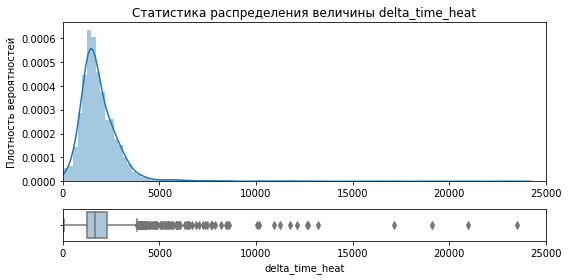

count         mean          std   min     25%     50%  \
delta_time_heat  3214.0  1897.954885  1265.435016  57.0  1260.0  1661.0   

                     75%      max  
delta_time_heat  2285.75  23485.0

In [9]:
# Оценка общего времени, потраченного на цикл нагревов delta_time_heat
df = pd.DataFrame(columns=['key','init_time','final_time'])
df['key'] = data_arc.key.unique()

for n, i in enumerate(data_arc.key.unique()):
    df.loc[n,'init_time'] = data_arc.loc[data_arc.key==i,'begin_heat'].values[0]
    df.loc[n,'final_time'] = data_arc.loc[data_arc.key==i,'end_heat'].values[-1]

df['delta_time_heat'] = df.apply(lambda row: 
    row['final_time'] - row['init_time'] if row['init_time'] < row['final_time'] else 86400 - row['init_time'] + row['final_time']
, axis=1).astype(int)

basic_statistics_numerical_features_(
    data=df['delta_time_heat'], bins=100, set_lim=[0, 25000], 
    title='Статистика распределения величины delta_time_heat',
    xlabel='delta_time_heat', 
)
pd.DataFrame(df.delta_time_heat.describe()).T

Оценка центрального положения признака `'delta_time_heat'` характеризуются небольшой правостроронней скошенностью с длинным узким хвостов, в следствии чего медианное и среднее значение отличается на 12%. Оценка вариабельности выборки показывает огромное отличие размаха диапазона значений хвостов выборки 25%-min=1203 и max-75%=21200, что свидетельствует о большой величине выбросов. Размах выборок в 23 раза больше интерквантильного размаха, что говорит о наличии значительного числа выбросов.

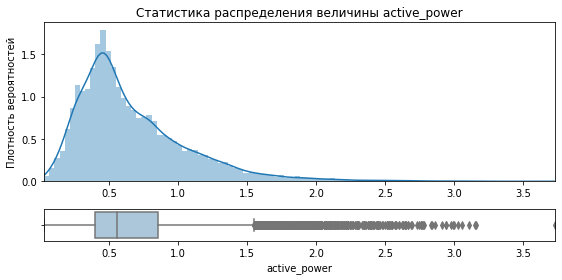

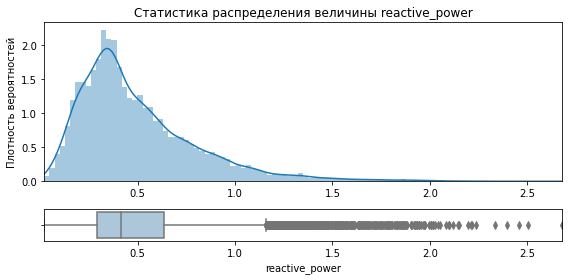

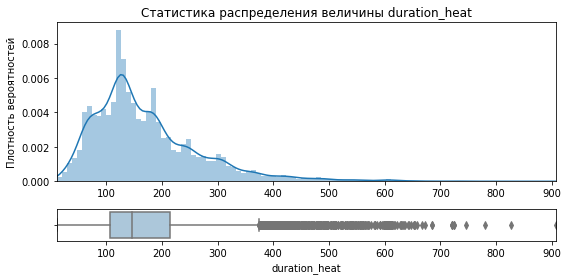

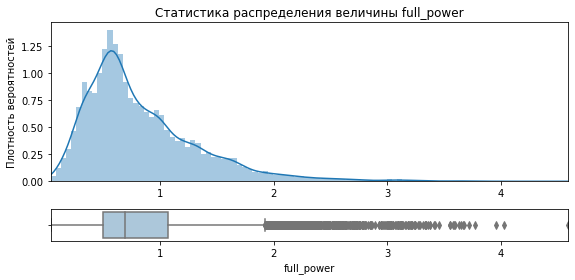

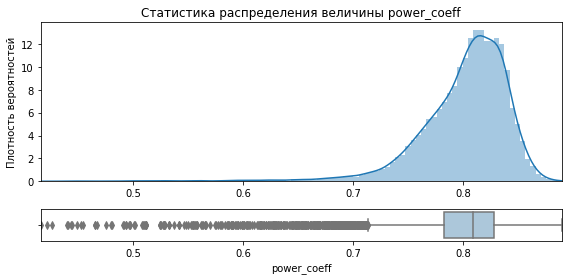

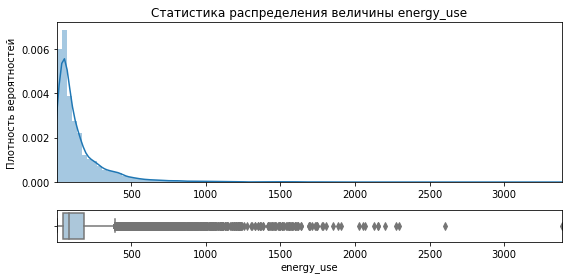

In [10]:
# Исследование распределения признаков
for col in data_arc.drop(['key','begin_heat','end_heat'], axis=1).columns:
    val_min = data_arc[col].min()
    val_max = data_arc[col].max()
    basic_statistics_numerical_features_(
        data=data_arc[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )

In [11]:
dataframe_summary(data_arc.drop(['key','begin_heat','end_heat'], axis=1))

active_power reactive_power duration_heat full_power  \
data type              float64        float64         int64    float64   
count passes                 0              0             0          0   
count duplicates             0              0             0          0   
average_truncated         0.62           0.46        159.57       0.77   
count                  14876.0        14876.0       14876.0    14876.0   
mean                      0.67            0.5        171.67       0.84   
std                       0.41           0.31         98.19       0.51   
min                       0.03           0.02          11.0       0.04   
25%                        0.4           0.29         107.0        0.5   
50%                       0.56           0.42         147.0       0.69   
75%                       0.86           0.64         214.0       1.07   
max                       3.73           2.68         907.0       4.59   
emissions                  569            600           617        597   

                  power_coeff energy_use  
data type             float64    float64  
count passes                0          0  
count duplicates            0          0  
average_truncated        0.81     112.18  
count                 14876.0    14876.0  
mean                      0.8     154.13  
std                      0.04     206.35  
min                      0.42       0.33  
25%                      0.78      42.88  
50%                      0.81      80.93  
75%                      0.83     182.02  
max                      0.89    3384.56  
emissions                 479       1324

- Оценка центрального положения показывает, что признаки `'active_power'`, `'reactive_power'`, `'full_power'` и `'duration_heat'` характеризуются небольшой правосторонней скошенностью, в следствии чего медианное и среднее значение отличается примерно на 15%, а усечённое среднее значение не значительно отличается от собственно среднего. Оценка вариабельности выборки `'active_power'`, `'reactive_power'`, `'full_power'` и `'duration_heat'` показывает схожее соотношение дисперсии со средним значением, размах диапазона значений хвостов 25%-min и max-75% (0.37/2.9, 0.27/2.04, 0.46/3.52, 96/693) так же свидетельствует о довольно схожей правосторонней асимметрии наблюдаемых распределений. Размах выборок в 8/7.6/8.0/8.4 раза больше интерквантильного размаха, что говорит о наличии весомого числа выбросов. Из выше сказанного можно предположить, что логарифмирование данных вполне может улучшить результаты работы ML.
- Оценка центрального положения признака `'power_coeff'` характеризуются слабой левосторонней скошенностью, в следствии чего медианное и среднее значение отличается незначительно, а усечённое среднее равно медианному. Оценка вариабельности выборки показывает слабое отличие размаха диапазона значений хвостов выборки 25%-min=0.36 и max-75%=0.06. Размах выборок в 9 раза больше интерквантильного размаха, что говорит о наличии значительного числа выбросов.
- Оценка центрального положения признака `'energy_use'` характеризуются значительной правосторонней скошенностью, в следствии чего медианное и среднее значение отличается примерно на 47%, а усечённое среднее значение значительно отличается от собственно среднего. Оценка вариабельности выборки показывает сильное отличие размаха диапазона значений хвостов выборки 25%-min=42.5 и max-75%=3203 так же свидетельствует о сильной правосторонней асимметрии наблюдаемого распределения. Размах выборок в 24 раза больше интерквантильного размаха, что говорит о наличии большого числа выбросов. Из выше сказанного можно предположить, что логарифмирование и частичное удаление выбросов может улучшить результаты работы ML.

In [12]:
# Агрегация наблюдений и генерация дополнительных признаков
data_arc = data_arc.groupby('key').agg({
    'active_power': ['mean','std','min','max'],
    'reactive_power': ['mean','std','min','max'],
    'duration_heat': ['sum','std','min','max','count'],
    'full_power': ['mean','std','min','max'],
    'power_coeff': ['mean','std','min','max'],
    'energy_use': ['sum','std','min','max'],
})
data_arc.columns = ['_'.join(name) for name in data_arc.columns] # Убираем мультииндексность колонок
data_arc['delta_time_heat'] = df.delta_time_heat
print('Размеры таблицы:', data_arc.shape)
data_arc.head(3)

Размеры таблицы: (3214, 26)


active_power_mean  active_power_std  active_power_min  active_power_max  \
key                                                                            
1             0.975629          0.396831          0.692755          1.659363   
2             0.763150          0.395234          0.438063          1.296415   
3             0.505176          0.325336          0.250280          1.062053   

     reactive_power_mean  reactive_power_std  reactive_power_min  \
key                                                                
1               0.636648            0.257863            0.414397   
2               0.499528            0.282637            0.283043   
3               0.319815            0.206361            0.155901   

     reactive_power_max  duration_heat_sum  duration_heat_std  \
key                                                             
1              1.062669               1098          86.315120   
2              0.892914                811          97.568352   
3              0.671494                655          86.611200   

     duration_heat_min  duration_heat_max  duration_heat_count  \
key                                                              
1                  148                365                    5   
2                  126                338                    4   
3                   65                280                    5   

     full_power_mean  full_power_std  full_power_min  full_power_max  \
key                                                                    
1           1.165279        0.472326        0.807239        1.970470   
2           0.912304        0.485382        0.521549        1.574162   
3           0.597907        0.385252        0.294865        1.256527   

     power_coeff_mean  power_coeff_std  power_coeff_min  power_coeff_max  \
key                                                                        
1            0.837756         0.014935         0.817717         0.858178   
2            0.840158         0.011797         0.823559         0.848934   
3            0.845421         0.003176         0.840526         0.848795   

     energy_use_sum  energy_use_std  energy_use_min  energy_use_max  \
key                                                                   
1       1207.804249      208.395795      102.527702      605.667332   
2        733.816470      177.972167       60.014678      438.188301   
3        443.583327      117.974537       16.268194      297.374822   

     delta_time_heat  
key                   
1             1144.0  
2             1525.0  
3             1093.0

### **2.2. Данные о продувке сплава газом 'data_gas'**

In [13]:
# Загрузка таблицы data_gas
case_ids = '''
    SELECT 
        "key",
        CAST("gas" AS float8)
    FROM steel.data_gas;
'''
data_gas = pd.read_sql_query(case_ids, con=engine_cloud)

display(data_gas.head(3))
dataframe_summary(data_gas)

key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793

key      gas
data type            int64  float64
count passes             0        0
count duplicates         0        0
average_truncated   1622.0    10.33
count               3239.0   3239.0
mean               1621.86     11.0
std                 935.39     6.22
min                    1.0     0.01
25%                  812.5     7.04
50%                 1622.0     9.84
75%                 2431.5    13.77
max                 3241.0     78.0
emissions                0      126

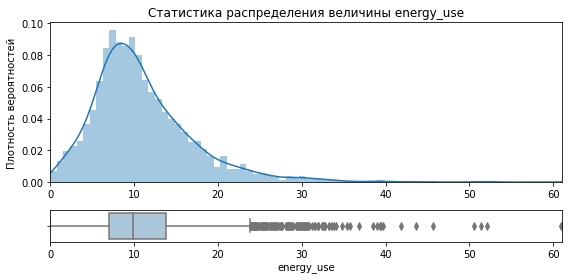

In [14]:
basic_statistics_numerical_features_(
    data=data_gas['gas'], bins=100, set_lim=[0,61], 
    title=f'Статистика распределения величины {col}',
    xlabel=col, 
)

Оценка центрального положения признака `'gas'` характеризуются правосторонней скошенностью, медианное и среднее значение отличается на 10%, усечённое среднее незначительно отличается от среднего. Оценка вариабельности выборки показывает сильное отличие размаха диапазона значений хвостов выборки 25%-min=7 и max-75%=64, что так же свидетельствует о сильной правосторонней асимметрии наблюдаемого распределения. Размах выборок в 11.5 раза больше интерквантильного размаха, что говорит о наличии больших выбросов. Из выше сказанного можно предположить, что логарифмирование и частичное удаление выбросов может улучшить результаты работы ML.

### **2.3. Данные об изменениях температуры 'data_temp'**

In [15]:
# Загрузка таблицы data_temp
case_ids = '''
    SELECT 
        "key",
        CAST(EXTRACT(HOUR FROM "MesaureTime") * 3600 + EXTRACT(MINUTE FROM "MesaureTime") * 60 + EXTRACT(SECOND FROM "MesaureTime") AS int) AS mesaure_time,
        CAST("Temperature" AS float8) AS temp
    FROM steel.data_temp;
'''
data_temp = pd.read_sql_query(case_ids, con=engine_cloud)

display(data_temp.head(3))
dataframe_summary(data_temp)

key  mesaure_time    temp
0    1         40578  1571.0
1    1         41153  1604.0
2    1         41351  1618.0

key mesaure_time     temp
data type            int64        int64  float64
count passes             0            0     2901
count duplicates         0            0        0
average_truncated  1608.63     43126.78      NaN
count              15907.0      15907.0  13006.0
mean               1607.88     43147.68  1591.84
std                 942.21     25089.38    21.38
min                    1.0         12.0   1191.0
25%                  790.0      21674.0   1581.0
50%                 1618.0      42894.0   1591.0
75%                 2427.0      64953.5   1601.0
max                 3241.0      86394.0   1705.0
emissions                0            0      723

In [16]:
# Фильтрация пропусков
filtr_ind = data_temp[data_temp.temp.isna()].key.unique()
data_temp = data_temp[~data_temp.key.isin(filtr_ind)]

# Фильтрация партий с единичным значением
filtr_ind = data_temp.key.value_counts()[data_temp.key.value_counts()==1].index
data_temp = data_temp[~data_temp.key.isin(filtr_ind)]

data_temp.shape

(12265, 3)

В данных обнаружено 2901 пропусков, в 739 партиях. При этом во всех 739 партиях присутствует только одно числовое значение, среди всех циклов обработки, а значит данные партии можно смело исключать. Итого отфильтровав искомые партии, мы удалим 3640 (22.9%) наблюдений.

In [17]:
# Исправление аномальных значений (банально руками быстрей)
data_temp.loc[4350,'temp'] = 1575.0
data_temp.loc[5978,'temp'] = 1608.0
data_temp.loc[7958,'temp'] = 1623.0
data_temp.loc[8913,'temp'] = 1680.0
data_temp.loc[8914,'temp'] = 1680.0
data_temp.loc[10127,'temp'] = 1592.0

В данных обнаружено 6 анамально низких значений, в 5 партиях. Как правило аномальные значения являются первыми измерениями, и их можно откорректировать, заменив на следующее.

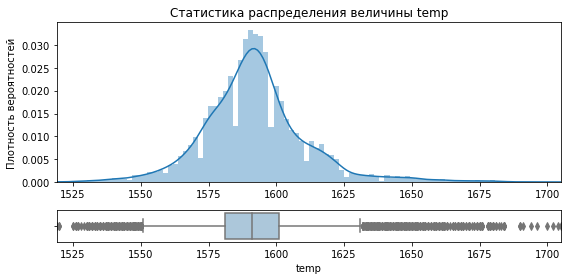

data type count passes count duplicates average_truncated    count  \
temp   float64            0                0           1591.28  12265.0   

         mean    std     min     25%     50%     75%     max emissions  
temp  1592.17  19.52  1519.0  1581.0  1591.0  1601.0  1705.0       634

In [18]:
basic_statistics_numerical_features_(
    data=data_temp['temp'], bins=100, set_lim=[1519,1705],
    title=f'Статистика распределения величины temp',
    xlabel='temp',
)
pd.DataFrame(dataframe_summary(data_temp).temp).T

Оценка центрального положения признака `'temp'` характеризуются колоколообразной формой распределения, медианное и среднее значение почти не отличаются, усечённое среднее идентично медианному. Оценка вариабельности выборки показывает слабое отличие размаха диапазона значений хвостов выборки 25%-min=62 и max-75%=104, 
что свидетельствует о близости распределения к нормальной форме. Размах выборок в 9,3 раза больше интерквантильного размаха, что говорит о наличии выбросов.

In [19]:
# Агрегация наблюдений
df_temp = pd.DataFrame(columns=['key','init_temp','final_temp'])
df_temp['key'] = data_temp.key.unique()

for n, i in enumerate(data_temp.key.unique()):
    df_temp.loc[n,'init_temp'] = data_temp.loc[data_temp.key==i,'temp'].values[0]
    df_temp.loc[n,'final_temp'] = data_temp.loc[data_temp.key==i,'temp'].values[-1]

df_temp[['init_temp','final_temp']] = df_temp[['init_temp','final_temp']].astype(int)
print('Размеры таблицы:', df_temp.shape)
display(df_temp.head(3))

del data_temp

Размеры таблицы: (2475, 3)


key  init_temp  final_temp
0    1       1571        1613
1    2       1581        1602
2    3       1596        1599

### **2.4. Данные об объёме сыпучих материалов 'data_bulk'**

In [21]:
# Загрузка таблицы data_bulk
case_ids = '''
    SELECT
        "key",
        CAST("Bulk 1" AS float8) AS bulk_1,
        CAST("Bulk 2" AS float8) AS bulk_2,
        CAST("Bulk 3" AS float8) AS bulk_3,
        CAST("Bulk 4" AS float8) AS bulk_4,
        CAST("Bulk 5" AS float8) AS bulk_5,
        CAST("Bulk 6" AS float8) AS bulk_6,
        CAST("Bulk 7" AS float8) AS bulk_7,
        CAST("Bulk 8" AS float8) AS bulk_8,
        CAST("Bulk 9" AS float8) AS bulk_9,
        CAST("Bulk 10" AS float8) AS bulk_10,
        CAST("Bulk 11" AS float8) AS bulk_11,
        CAST("Bulk 12" AS float8) AS bulk_12,
        CAST("Bulk 13" AS float8) AS bulk_13,
        CAST("Bulk 14" AS float8) AS bulk_14,
        CAST("Bulk 15" AS float8) AS bulk_15
    FROM steel.data_bulk;
'''
data_bulk = pd.read_sql_query(case_ids, con=engine_cloud)
data_bulk.drop(303, axis=0, inplace=True)

display(data_bulk.head(3))
dataframe_summary(data_bulk)

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0

key   bulk_1   bulk_2   bulk_3   bulk_4   bulk_5  \
data type            int64  float64  float64  float64  float64  float64   
count passes             0     2877     3106     1831     2115     3051   
count duplicates         0        0        0        0        0        0   
average_truncated  1624.82      NaN      NaN      NaN      NaN      NaN   
count               3128.0    251.0     22.0   1297.0   1013.0     77.0   
mean                1624.8    38.66   253.05   113.89   104.44   107.03   
std                  933.2    15.81    21.18    75.51    48.19    81.79   
min                    1.0     10.0    228.0      6.0     12.0     11.0   
25%                 816.75     27.0    242.0     58.0     72.0     70.0   
50%                 1623.0     31.0    251.5     97.0    102.0     86.0   
75%                2431.25     46.0   257.75    152.0    133.0    132.0   
max                 3241.0    118.0    325.0    454.0    281.0    603.0   
emissions                0        9        2       38       18        5   

                    bulk_6   bulk_7   bulk_8   bulk_9  bulk_10  bulk_11  \
data type          float64  float64  float64  float64  float64  float64   
count passes          2552     3104     3127     3109     2952     2951   
count duplicates         0        0        0        0        0        0   
average_truncated      NaN      NaN      NaN      NaN      NaN      NaN   
count                576.0     24.0      1.0     19.0    176.0    177.0   
mean                118.93   301.42     49.0    76.32    83.28    76.82   
std                  72.06   193.96      NaN    21.72    26.06    59.66   
min                   17.0     47.0     49.0     63.0     24.0      8.0   
25%                  69.75   143.25     49.0     66.0     64.0     25.0   
50%                  100.0    297.0     49.0     68.0     86.5     64.0   
75%                  157.0   419.25     49.0     70.5    102.0    106.0   
max                  503.0    772.0     49.0    147.0    159.0    313.0   
emissions               16        0        0        3        0        2   

                   bulk_12  bulk_13  bulk_14  bulk_15  
data type          float64  float64  float64  float64  
count passes           679     3110      323      880  
count duplicates         0        0        0        0  
average_truncated      NaN      NaN      NaN      NaN  
count               2449.0     18.0   2805.0   2248.0  
mean                259.82   181.11   170.12   160.51  
std                 116.32    46.09    65.29    51.77  
min                   53.0    151.0     16.0      1.0  
25%                  204.0   153.25    119.0    105.0  
50%                  208.0    155.5    151.0    160.0  
75%                  316.0    203.5    205.0    205.0  
max                  853.0    305.0    601.0    405.0  
emissions              101        1       58        2

В данных обнаружено одно аномально высокое значение (1849), в партии №322, данная партия исключена из анализа.

Признаки характеризуются большим разнообразием частот количества значений 1-2805, в следствии чего можно наблюдать пропуски в диапазоне 99.9-10.4%.

Наибольшая частота обработак (88% всего количества) происходит на 3, 4, 12, 14 и 15 цикла, что соответствует 94% всего объёма материала.

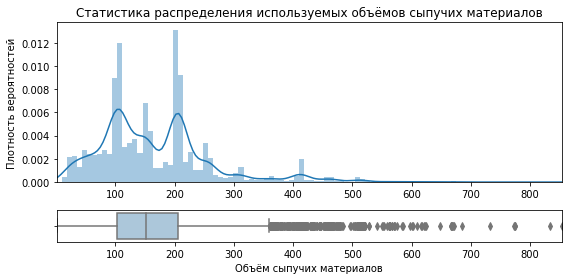

count       mean        std  min    25%    50%    75%    max
0  11153.0  166.77979  96.610958  1.0  103.0  152.0  206.0  853.0

In [22]:
# Исследование распределения значений признаков
basic_statistics_numerical_features_(
    data=data_bulk.drop('key',axis=1).values.reshape(-1), bins=100, set_lim=[1,853],
    title='Статистика распределения используемых объёмов сыпучих материалов',
    xlabel='Объём сыпучих материалов',
)
pd.DataFrame(data_bulk.drop('key',axis=1).values.reshape(-1)).describe().T

По объёмам используемого материала наиболее частыми можно отметить значения, распределение которых концентрируется вокруг 100, 150, 200, 250, 300 и 400.

Оценка центрального положения значений признаков `'bulk_1-15'` характеризуются сильной правосторонней скошенностью, медианное и среднее значение отличается на 9%. Оценка вариабельности выборки показывает значительное отличие размаха диапазона значений хвостов выборки 25%-min=102 и max-75%=647, что так же свидетельствует о сильной правосторонней асимметрии наблюдаемого распределения. Размах выборок в 8 раза больше интерквантильного размаха, что говорит о наличии большого числа выбросов.

In [23]:
# Агрегация/создание дополнительных признаков
data_bulk['sum_bulk'] = data_bulk.iloc[:,1:16].sum(axis=1)
data_bulk['count_bulk'] = data_bulk.iloc[:,1:16].count(axis=1)
data_bulk['std_bulk'] = data_bulk.iloc[:,1:16].std(axis=1)

data_bulk.shape

(3128, 19)

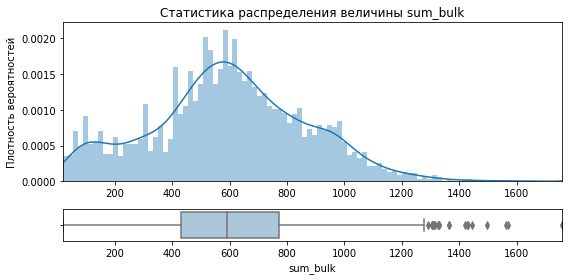

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  sum_bulk  \
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0     553.0   
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0     582.0   
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0     544.0   

   count_bulk   std_bulk  
0           4  68.431840  
1           4  54.775299  
2           4  72.364816

key sum_bulk count_bulk std_bulk
data type            int64  float64      int64  float64
count passes             0        0          0      296
count duplicates         0        0          0        0
average_truncated  1624.82   594.86       3.67    90.21
count               3128.0   3128.0     3128.0   2832.0
mean                1624.8   594.66       3.57    84.15
std                  933.2   272.54       1.22    46.69
min                    1.0     19.0        1.0     1.15
25%                 816.75    429.0        3.0    52.54
50%                 1623.0    591.0        4.0    71.85
75%                2431.25    772.0        4.0   110.25
max                 3241.0   1757.0        7.0   358.83
emissions                0       20        367       78

In [24]:
# Исследование распределения признаков
for col in ['sum_bulk']:
    val_min = data_bulk[col].min()
    val_max = data_bulk[col].max()
    basic_statistics_numerical_features_(
        data=data_bulk[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )

display(data_bulk.head(3))
dataframe_summary(data_bulk.drop(data_bulk.iloc[:,1:16].columns, axis=1))

Оценка центрального положения признака `'sum_bulk'` характеризуются очень слабой правосторонней скошенностью, медианное и среднее значение отличается незначительно, усечённое среднее аналогично среднему значению. Оценка вариабельности выборки показывает значительное отличие размаха диапазона значений хвостов выборки 25%-min=410 и max-75%=985, что так же свидетельствует о правосторонней асимметрии наблюдаемого распределения. Размах выборок в 5 раза больше интерквантильного размаха, что говорит о наличии небольшого числа выбросов.

### **2.5. Данные о времени подачи сыпучих материалов 'data_bulk_time'**

In [25]:
# Загрузка таблицы data_bulk_time
case_ids = '''
    SELECT
        "key",
        CAST(EXTRACT(HOUR FROM "Bulk 1") * 3600 + EXTRACT(MINUTE FROM "Bulk 1") * 60 + EXTRACT(SECOND FROM "Bulk 1") AS int) AS bulk_1,
        CAST(EXTRACT(HOUR FROM "Bulk 2") * 3600 + EXTRACT(MINUTE FROM "Bulk 2") * 60 + EXTRACT(SECOND FROM "Bulk 2") AS int) AS bulk_2,
        CAST(EXTRACT(HOUR FROM "Bulk 3") * 3600 + EXTRACT(MINUTE FROM "Bulk 3") * 60 + EXTRACT(SECOND FROM "Bulk 3") AS int) AS bulk_3,
        CAST(EXTRACT(HOUR FROM "Bulk 4") * 3600 + EXTRACT(MINUTE FROM "Bulk 4") * 60 + EXTRACT(SECOND FROM "Bulk 4") AS int) AS bulk_4,
        CAST(EXTRACT(HOUR FROM "Bulk 5") * 3600 + EXTRACT(MINUTE FROM "Bulk 5") * 60 + EXTRACT(SECOND FROM "Bulk 5") AS int) AS bulk_5,
        CAST(EXTRACT(HOUR FROM "Bulk 6") * 3600 + EXTRACT(MINUTE FROM "Bulk 6") * 60 + EXTRACT(SECOND FROM "Bulk 6") AS int) AS bulk_6,
        CAST(EXTRACT(HOUR FROM "Bulk 7") * 3600 + EXTRACT(MINUTE FROM "Bulk 7") * 60 + EXTRACT(SECOND FROM "Bulk 7") AS int) AS bulk_7,
        CAST(EXTRACT(HOUR FROM "Bulk 8") * 3600 + EXTRACT(MINUTE FROM "Bulk 8") * 60 + EXTRACT(SECOND FROM "Bulk 8") AS int) AS bulk_8,
        CAST(EXTRACT(HOUR FROM "Bulk 9") * 3600 + EXTRACT(MINUTE FROM "Bulk 9") * 60 + EXTRACT(SECOND FROM "Bulk 9") AS int) AS bulk_9,
        CAST(EXTRACT(HOUR FROM "Bulk 10") * 3600 + EXTRACT(MINUTE FROM "Bulk 10") * 60 + EXTRACT(SECOND FROM "Bulk 10") AS int) AS bulk_10,
        CAST(EXTRACT(HOUR FROM "Bulk 11") * 3600 + EXTRACT(MINUTE FROM "Bulk 11") * 60 + EXTRACT(SECOND FROM "Bulk 11") AS int) AS bulk_11,
        CAST(EXTRACT(HOUR FROM "Bulk 12") * 3600 + EXTRACT(MINUTE FROM "Bulk 12") * 60 + EXTRACT(SECOND FROM "Bulk 12") AS int) AS bulk_12,
        CAST(EXTRACT(HOUR FROM "Bulk 13") * 3600 + EXTRACT(MINUTE FROM "Bulk 13") * 60 + EXTRACT(SECOND FROM "Bulk 13") AS int) AS bulk_13,
        CAST(EXTRACT(HOUR FROM "Bulk 14") * 3600 + EXTRACT(MINUTE FROM "Bulk 14") * 60 + EXTRACT(SECOND FROM "Bulk 14") AS int) AS bulk_14,
        CAST(EXTRACT(HOUR FROM "Bulk 15") * 3600 + EXTRACT(MINUTE FROM "Bulk 15") * 60 + EXTRACT(SECOND FROM "Bulk 15") AS int) AS bulk_15
    FROM steel.data_bulk_time;
'''
data_bulk_time = pd.read_sql_query(case_ids, con=engine_cloud)
data_bulk_time.head(3)

key  bulk_1  bulk_2  bulk_3   bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN  40890.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN  42398.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN  45066.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN  39832.0      NaN  39832.0  39832.0  
1     NaN      NaN      NaN  42020.0      NaN  42020.0  42020.0  
2     NaN      NaN      NaN  43780.0      NaN  43780.0  43780.0

Направление движения времени подачи сыпучих материалов идёт в противоположном направлении от обозначенного порядка признаков - данное свойство не описано в задании проекта. Часто в одних и тех же наблюдениях встречаются ряды с одинаковыми значениями времени в разные циклы обработки, данное явление невозможно физически, либо подразумевается некоторое иное технологическое явление, однако указаний на это в описании проекта отсутствует, поэтому эти данные решено оставить . У 14% наблюдений нарушается равномерный порядок изменения значений времени, если исходить из того, что данные о времени даны точные, то случаи, когда нарушается равномерный порядок изменения ряда, может свидетельствовать о переходе технологического процесса на следующие сутки.

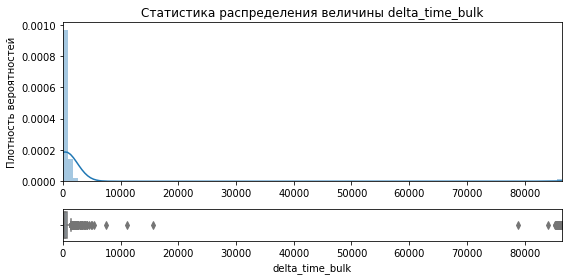

count         mean           std  min    25%    50%    75%  \
delta_time_bulk  3129.0  1716.704698  10171.813626  0.0  139.0  378.0  646.0   

                     max  
delta_time_bulk  86399.0

In [26]:
# Оценка общего времени, потраченного на цикл добавления сыпучих материалов delta_time_bulk
df = pd.DataFrame(columns=['key','init_time','final_time'])
df['key'] = data_bulk_time.key.unique()

for n, i in enumerate(data_bulk_time.key.unique()):
    array = data_bulk_time.loc[data_bulk_time.key==i].drop('key',axis=1).values[0]
    df.loc[n,'init_time'] = array[~np.isnan(array)][-1]
    df.loc[n,'final_time'] = array[~np.isnan(array)][0]

df['delta_time_bulk'] = df.apply(lambda row: 
    row['final_time'] - row['init_time'] if row['init_time'] < row['final_time'] else 86400 - row['init_time'] + row['final_time']
, axis=1).astype(int)

# Pfgjkyt
df.loc[df.init_time==df.final_time, 'delta_time_bulk'] = 0

basic_statistics_numerical_features_(
    data=df['delta_time_bulk'], bins=100, set_lim=[0, 86400], 
    title='Статистика распределения величины delta_time_bulk',
    xlabel='delta_time_bulk', 
)
pd.DataFrame(df.delta_time_bulk.describe()).T

Удаление наблюдений с длительностью около суток приводит к заметному ухудшению целевой метрики, следовательно, данная методика не подходит для улучшения качества прогнозирования.

Альтернативной идеей выявления нетипичных наблюдений является оценка статистического разброса значений в массиве времени для каждого наблюдения. Для этого массив будет приведён к синусоидальной форме распределения и будет проведено вычисление значения стандартного отклонения, то есть оценка близости значений.

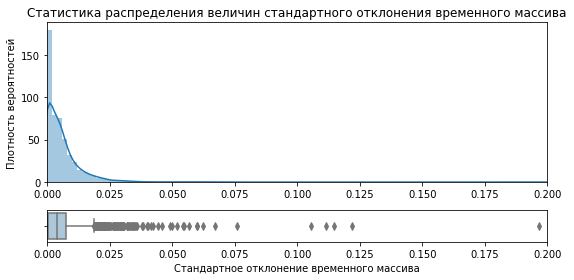

Список пактий с аномальным временем подачи материала: [ 641  801 1513 1689 2150 2965]


In [27]:
bulk_time_std = pd.DataFrame(columns=['key','time_array','time_bulk_std'])
bulk_time_std['key'] = data_bulk_time.key.unique()

for n, i in enumerate(data_bulk_time.key.unique()):
    array = data_bulk_time.loc[data_bulk_time.key==i].drop('key',axis=1).values[0]
    array = array[~np.isnan(array)]
    bulk_time_std.loc[n,'time_array'] = str(array)
    bulk_time_std.loc[n,'time_bulk_std'] = np.std(np.sin(array * np.pi / 86400))

basic_statistics_numerical_features_(
    data=bulk_time_std['time_bulk_std'], bins=100, set_lim=[0,0.2],
    title=f'Статистика распределения величин стандартного отклонения временного массива',
    xlabel='Стандартное отклонение временного массива',
)
print('Список пактий с аномальным временем подачи материала:', bulk_time_std[bulk_time_std.time_bulk_std > 0.07].key.values)

In [28]:
print('Размер таблицы data_bulk до фильтрации', data_bulk.shape)
data_bulk = data_bulk[~data_bulk.key.isin(bulk_time_std[bulk_time_std.time_bulk_std > 0.07].key.values)]
print('Размер таблицы data_bulk после фильтрации', data_bulk.shape)

Размер таблицы data_bulk до фильтрации (3128, 19)
Размер таблицы data_bulk после фильтрации (3122, 19)


Отфильтровав шесть партии, со значением стандартного отклонения более 0.07, получаем улучшение целевой метрики, что может свидетельствовать о том, что отфильтрованные партии по всей видимости содержали зашумленные данные.

### **2.6. Данные об объёме проволочных материалов 'data_wire'**

In [29]:
# Загрузка таблицы data_wire
case_ids = '''
    SELECT
        "key",
        CAST("Wire 1" AS float8) AS wire_1,
        CAST("Wire 2" AS float8) AS wire_2,
        CAST("Wire 3" AS float8) AS wire_3,
        CAST("Wire 4" AS float8) AS wire_4,
        CAST("Wire 5" AS float8) AS wire_5,
        CAST("Wire 6" AS float8) AS wire_6,
        CAST("Wire 7" AS float8) AS wire_7,
        CAST("Wire 8" AS float8) AS wire_8,
        CAST("Wire 9" AS float8) AS wire_9
    FROM steel.data_wire;
'''
data_wire = pd.read_sql_query(case_ids, con=engine_cloud)

display(data_wire.head(3))
dataframe_summary(data_wire.drop('key',axis=1))

key     wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN

wire_1   wire_2   wire_3   wire_4   wire_5   wire_6  \
data type          float64  float64  float64  float64  float64  float64   
count passes            26     2002     3018     3067     3080     3008   
count duplicates       428      428      428      428      428      428   
average_truncated   100.62      NaN      NaN      NaN      NaN      NaN   
count               3055.0   1079.0     63.0     14.0      1.0     73.0   
mean                 100.9    50.58   189.48    57.44    15.13    48.02   
std                  42.01    39.32    99.51    28.82      NaN    33.92   
min                   1.92     0.03     0.14    24.15    15.13     0.03   
25%                  72.12    20.19    95.14    40.81    15.13    25.05   
50%                 100.16    40.14   235.19    45.23    15.13    42.08   
75%                 126.06    70.23   276.25    76.12    15.13    64.21   
max                 330.31   282.78   385.01   113.23    15.13   180.45   
emissions               36       32        0        0        0        3   

                    wire_7   wire_8   wire_9  
data type          float64  float64  float64  
count passes          3070     3062     3052  
count duplicates       428      428      428  
average_truncated      NaN      NaN      NaN  
count                 11.0     19.0     29.0  
mean                 10.04    53.63    34.16  
std                   8.61    16.88    19.93  
min                   0.23    45.08     4.62  
25%                   6.76    46.09    22.06  
50%                   9.02    46.28    30.07  
75%                  11.89    48.09    43.86  
max                  32.85   102.76    90.05  
emissions                1        4        1

In [30]:
# Исследование распределения признаков по итерациям обработки
data = []
for col in data_wire.drop('key',axis=1).columns:
    data.append(go.Histogram(x=data_wire[col].values, nbinsx=10, name=col))

layout = go.Layout(
    title='Гистограмма на основе данных об объёме подаваемых на обработку проволочных материалов',
    xaxis=dict(title='Объём материала'),
    yaxis=dict(title='Частота операций')
)
fig = go.Figure(data=data, layout=layout)
fig.show()

Основное количество обработок происходит на первой и второй итерации (95% всего количества и объёма соответственно), в следствии чего основная доля пропусков наблюдается во всех остальных признаках 97.6-99.9%. По объёмам используемого материала наиболее частые значения находятся в диапазоне 0-300 с пиком плотности вероятности на 100.

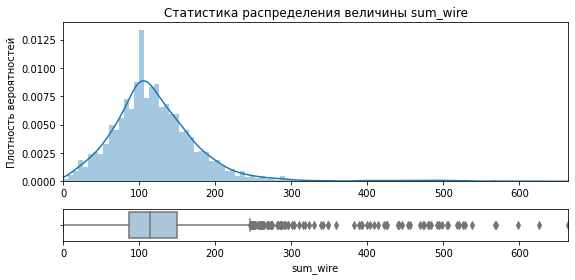

key     wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9   sum_wire  count_wire  std_wire  
0     NaN  60.059998           1       NaN  
1     NaN  96.052315           1       NaN  
2     NaN  91.160157           1       NaN

key sum_wire count_wire std_wire
data type            int64  float64      int64  float64
count passes             0        0          0     1939
count duplicates         0        0          0        0
average_truncated  1622.69   117.13       1.34      NaN
count               3081.0   3081.0     3081.0   1142.0
mean               1623.43    123.4        1.4    45.26
std                  933.0    65.55       0.56    32.09
min                    1.0      0.0        0.0      0.0
25%                  823.0    86.11        1.0    18.12
50%                 1619.0   114.16        1.0    39.66
75%                 2434.0   150.13        2.0    66.46
max                 3241.0   663.85        5.0   184.54
emissions                0      104         12        8

In [31]:
# Cоздание дополнительных признаков
data_wire['sum_wire'] = data_wire.iloc[:,1:9].sum(axis=1)
data_wire['count_wire'] = data_wire.iloc[:,1:9].count(axis=1)
data_wire['std_wire'] = data_wire.iloc[:,1:9].std(axis=1)

# Исследование распределения признаков
for col in ['sum_wire']:
    val_min = data_wire[col].min()
    val_max = data_wire[col].max()
    basic_statistics_numerical_features_(
        data=data_wire[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )

display(data_wire.head(3))
dataframe_summary(data_wire.drop(data_wire.iloc[:,1:10].columns, axis=1))

Оценка центрального положения признака `'sum_wire'` характеризуются слабой правосторонней скошенностью, медианное и среднее значение отличается незначительно, так же как и усечённое среднее. Оценка вариабельности выборки показывает значительное отличие размаха диапазона значений хвостов выборки 25%-min=86 и max-75%=513, что так же свидетельствует о правосторонней асимметрии наблюдаемого распределения. Размах выборок в 10 раза больше интерквантильного размаха, что говорит о наличии большого числа выбросов.

### **2.7. Данные о времени подачи проволочных материалов 'data_wire_time'**

In [32]:
# Загрузка таблицы data_wire_time
case_ids = '''
    SELECT
        "key",
        CAST(EXTRACT(HOUR FROM "Wire 1") * 3600 + EXTRACT(MINUTE FROM "Wire 1") * 60 + EXTRACT(SECOND FROM "Wire 1") AS int) AS wire_1,
        CAST(EXTRACT(HOUR FROM "Wire 2") * 3600 + EXTRACT(MINUTE FROM "Wire 2") * 60 + EXTRACT(SECOND FROM "Wire 2") AS int) AS wire_2,
        CAST(EXTRACT(HOUR FROM "Wire 3") * 3600 + EXTRACT(MINUTE FROM "Wire 3") * 60 + EXTRACT(SECOND FROM "Wire 3") AS int) AS wire_3,
        CAST(EXTRACT(HOUR FROM "Wire 4") * 3600 + EXTRACT(MINUTE FROM "Wire 4") * 60 + EXTRACT(SECOND FROM "Wire 4") AS int) AS wire_4,
        CAST(EXTRACT(HOUR FROM "Wire 5") * 3600 + EXTRACT(MINUTE FROM "Wire 5") * 60 + EXTRACT(SECOND FROM "Wire 5") AS int) AS wire_5,
        CAST(EXTRACT(HOUR FROM "Wire 6") * 3600 + EXTRACT(MINUTE FROM "Wire 6") * 60 + EXTRACT(SECOND FROM "Wire 6") AS int) AS wire_6,
        CAST(EXTRACT(HOUR FROM "Wire 7") * 3600 + EXTRACT(MINUTE FROM "Wire 7") * 60 + EXTRACT(SECOND FROM "Wire 7") AS int) AS wire_7,
        CAST(EXTRACT(HOUR FROM "Wire 8") * 3600 + EXTRACT(MINUTE FROM "Wire 8") * 60 + EXTRACT(SECOND FROM "Wire 8") AS int) AS wire_8,
        CAST(EXTRACT(HOUR FROM "Wire 9") * 3600 + EXTRACT(MINUTE FROM "Wire 9") * 60 + EXTRACT(SECOND FROM "Wire 9") AS int) AS wire_9
    FROM steel.data_wire_time;
'''
data_wire_time = pd.read_sql_query(case_ids, con=engine_cloud)
data_wire_time.head(3)

key   wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  40301.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  42370.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  44027.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN

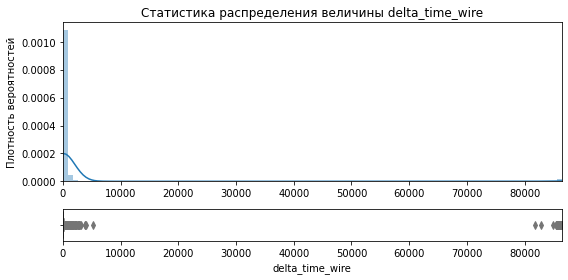

count         mean          std  min  25%  50%   75%  \
delta_time_wire  3081.0  1244.757222  9701.179376  0.0  0.0  0.0  79.0   

                     max  
delta_time_wire  86386.0

In [33]:
# Оценка общего времени, потраченного на цикл добавления проволочных материалов data_wire_time
df = pd.DataFrame(columns=['key','init_time','final_time'])
df['key'] = data_wire_time.key.unique()

for n, i in enumerate(data_wire_time.key.unique()):
    array = data_wire_time.loc[data_wire_time.key==i].drop('key',axis=1).values[0]
    df.loc[n,'init_time'] = array[~np.isnan(array)][0]
    df.loc[n,'final_time'] = array[~np.isnan(array)][-1]

df['delta_time_wire'] = df.apply(lambda row: 
    row['final_time'] - row['init_time'] if row['init_time'] < row['final_time'] else 86400 - row['init_time'] + row['final_time']
, axis=1).astype(int)

# Pfgjkyt
df.loc[df.init_time==df.final_time, 'delta_time_wire'] = 0

basic_statistics_numerical_features_(
    data=df['delta_time_wire'], bins=100, set_lim=[0, 86400], 
    title='Статистика распределения величины delta_time_wire',
    xlabel='delta_time_wire', 
)
pd.DataFrame(df.delta_time_wire.describe()).T

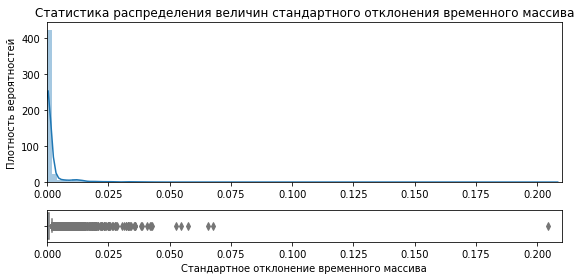

Список пактий с аномальным временем подачи материала: [2108]


In [34]:
wire_time_std = pd.DataFrame(columns=['key','time_array','time_wire_std'])
wire_time_std['key'] = data_wire_time.key.unique()

for n, i in enumerate(data_wire_time.key.unique()):
    array = data_wire_time.loc[data_wire_time.key==i].drop('key',axis=1).values[0]
    array = array[~np.isnan(array)]
    wire_time_std.loc[n,'time_array'] = str(array)
    wire_time_std.loc[n,'time_wire_std'] = np.std(np.sin(array * np.pi / 86400))

basic_statistics_numerical_features_(
    data=wire_time_std['time_wire_std'], bins=100, set_lim=[0,0.21],
    title=f'Статистика распределения величин стандартного отклонения временного массива',
    xlabel='Стандартное отклонение временного массива',
)
print('Список пактий с аномальным временем подачи материала:', wire_time_std[wire_time_std.time_wire_std > 0.2].key.values)

In [35]:
print('Размер таблицы data_wire до фильтрации', data_wire.shape)
data_wire = data_wire[~data_wire.key.isin(wire_time_std[wire_time_std.time_wire_std > 0.2].key.values)]
print('Размер таблицы data_wire после фильтрации', data_wire.shape)

Размер таблицы data_wire до фильтрации (3081, 13)
Размер таблицы data_wire после фильтрации (3080, 13)


В текущем параграфе использовался аналогичный подход, как и в параграфе анализа таблицы data_bulk_time. Была выявлена партия с аномально высоким значением стандартного отклонения более 0.2. Фильтрация соответствующей партии даёт улучшение целевой метрики, что может свидетельствовать о том, что отфильтрованная партия по всей видимости содержит зашумленные данные.

### **2.8. Промежуточные выводы**

- Данные об электродах 'data_arc' показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки. Было создано 5 дополнительных признаков: длительность нагрева `'duration_heat'`,
полная мощность `'full_power'`, коэффициент мощности `'power_coeff'`, энергопотребление `'energy_use'`, длительность между первым и последним циклом нагрева `'delta_time_heat'`. А также сгенерированы агрегированные значения признаков: mean, std, min, max, count. Все признаки характеризуются сильной правосторонней или левосторонней асимметрией с наличием большого числа выбросов.
- Данные о продувке сплава газом 'data_gas' характеризуются правосторонней асимметрией с наличием большого числа выбросов.
- Данные об изменениях температуры 'data_temp' показали шести аномальных температуры (ниже 1500 гдад), которые были исправлены на следующее адекватное в ряду. Начальное значение температуры выбрано за признак, конечное значение температуры выбрано в качестве целевого значения. Основное количество циклов нагрева для каждой партии `'duration_heat_count'` находится в диапазоне 4-7 раз (83% наблюдений), при этом наиболее редкими событиями являются 10 и более раз (0.6% наблюдений).
- Данные об объёме сыпучих материалов 'data_bulk' показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки. Признаки характеризуются большим разнообразием частот количества значений 1-2805, в следствии чего можно наблюдать пропуски в диапазоне 99.9-10.4%. Наибольшая частота обработак сыпучими материалами (88% всего количества) происходит на 3, 4, 12, 14 и 15 цикла, что соответствует 94% всего объёма материала. По объёмам используемого материала наиболее частыми можно отметить значения, распределение которых концентрируется вокруг 100, 150, 200, 250, 300 и 400. Основное количество циклов обработки сыпучими материалами для каждой партии `'count_bulk'` находится в диапазоне 4-6 раз (79% наблюдений), при этом наиболее редкими событиями являются 6 и более раз (2.2% наблюдений).
- Данные о времени подачи сыпучих материалов 'data_bulk_time' показали шести аномальных партий, в которых отмечена аномально высокая временная дисперсия подачи материала, выявленные партии были исключены из анализа. Направление движения времени подачи сыпучих материалов идёт в противоположном направлении от обозначенного порядка признаков - данное свойство не описано в задании проекта. Часто в одних и тех же наблюдениях встречаются ряды с одинаковыми значениями времени в разные циклы обработки, данное явление невозможно физически, либо подразумевается некоторое иное технологическое явление, однако указаний на это в описании проекта отсутствует, поэтому эти данные решено оставить. У 14% наблюдений нарушается равномерный порядок изменения значений времени, если исходить из того, что данные о времени даны точные, то случаи, когда нарушается равномерный порядок изменения ряда, может свидетельствовать о переходе технологического процесса на следующие сутки или ошибке внесения данных.
- Данные об объёме проволочных материалов 'data_wire'. Основное количество обработок происходит на первой и второй итерации (95% всего количества и объёма соответственно), в следствии чего основная доля пропусков наблюдается во всех остальных признаках 97.6-99.9%. По объёмам используемого материала наиболее частые значения находятся в диапазоне 0-300 с пиком плотности вероятности на 100. Основное количество циклов добавления легирующих материалов для каждой партии `'count_wire'` находится в диапазоне 2-3 раза (98% наблюдений), при этом наиболее редкими событиями являются 1 и 4 и более раз (0.3% наблюдений)

### **2.9. Объединение и анализ таблиц**

In [36]:
df_full = df_temp\
    .merge(data_arc, on='key', how='inner')\
    .merge(data_gas, on='key', how='inner')\
    .merge(data_bulk[['key','sum_bulk','count_bulk','std_bulk']].fillna(0), on='key', how='inner')\
    .merge(data_wire[['key','sum_wire','count_wire','std_wire']].fillna(0), on='key', how='inner')\
    .merge(bulk_time_std[['key','time_bulk_std']], on='key', how='inner')\
    .merge(wire_time_std[['key','time_wire_std']], on='key', how='inner')

# Фильтрация признаков и заполнение пропусков
features_drop = [
    'key','full_power_mean','full_power_std','full_power_min','full_power_max',
    'reactive_power_mean','reactive_power_std','reactive_power_min','reactive_power_max',
    'energy_use_std','energy_use_max','energy_use_sum',
    'duration_heat_max','duration_heat_min','duration_heat_std',
    'active_power_min','active_power_std','active_power_max',
    'power_coeff_std','power_coeff_max','power_coeff_min',
    'time_wire_std'
]
df_full = df_full.drop(features_drop, axis=1)
print('Количество пропусков', df_full.isna().sum().sum())
print('Размер выборки', df_full.shape)
df_full.head(3)

Количество пропусков 0
Размер выборки (2322, 16)


init_temp  final_temp  active_power_mean  duration_heat_sum  \
0       1571        1613           0.975629               1098   
1       1581        1602           0.763150                811   
2       1596        1599           0.505176                655   

   duration_heat_count  power_coeff_mean  energy_use_min  delta_time_heat  \
0                    5          0.837756      102.527702           1144.0   
1                    4          0.840158       60.014678           1525.0   
2                    5          0.845421       16.268194           1093.0   

         gas  sum_bulk  count_bulk   std_bulk   sum_wire  count_wire  \
0  29.749986     553.0           4  68.431840  60.059998           1   
1  12.555561     582.0           4  54.775299  96.052315           1   
2  28.554793     544.0           4  72.364816  91.160157           1   

   std_wire time_bulk_std  
0       0.0      0.001716  
1       0.0      0.000214  
2       0.0        0.0009

#### **2.9.1. Исследовательский анализ данных**

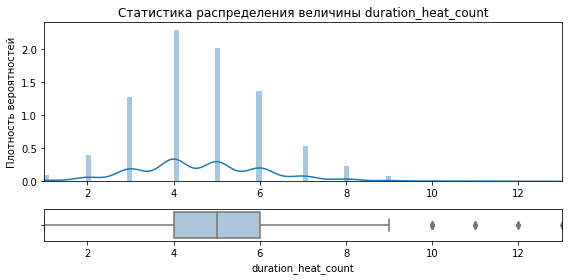

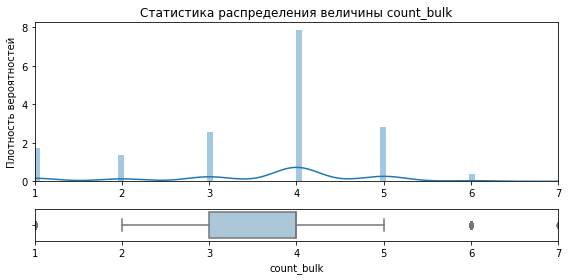

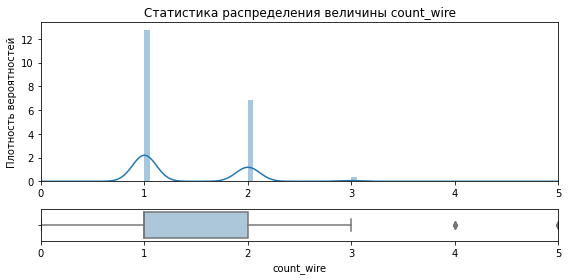

In [37]:
# Исследование распределения признаков 'duration_heat_count','count_bulk','count_wire'
for col in ['duration_heat_count','count_bulk','count_wire']:
    val_min = df_full[col].min()
    val_max = df_full[col].max()
    basic_statistics_numerical_features_(
        data=df_full[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )

- Основное количество циклов нагрева `'duration_heat_count'` находится в диапазоне 4-7 раз (83% наблюдений), при этом наиболее редкими событиями являются 10 и более раз (0.6% наблюдений).
- Основное количество циклов обработки сыпучими материалами `'count_bulk'` находится в диапазоне 4-6 раз (79% наблюдений), при этом наиболее редкими событиями являются 6 и более раз (2.2% наблюдений).
- Основное количество циклов добавления лигирующих материалов `'count_wire'` находится в диапазоне 2-3 раза (98% наблюдений), при этом наиболее редкими событиями являются 1 и 4 и более раз (0.3% наблюдений).

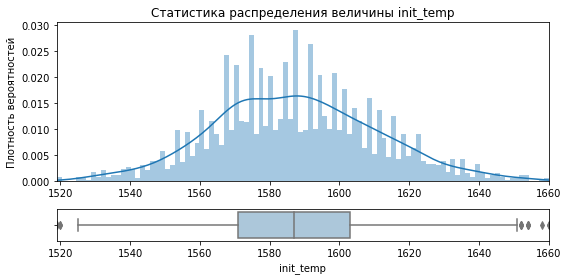

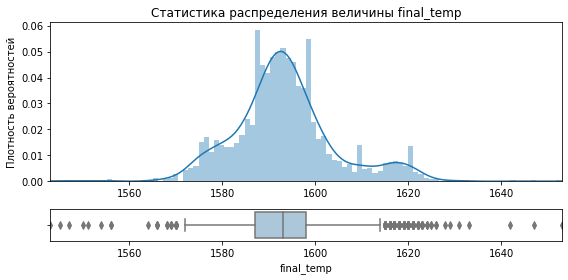

data type count passes count duplicates average_truncated   count  \
init_temp      int64            0              745           1587.01  2322.0   
final_temp     int64            0              745           1592.76  2322.0   

               mean    std     min     25%     50%     75%     max emissions  
init_temp   1587.34  23.58  1519.0  1571.0  1587.0  1603.0  1660.0        14  
final_temp   1593.4  11.14  1543.0  1587.0  1593.0  1598.0  1653.0       179

In [38]:
# Исследование распределения признаков 'init_temp','final_temp'
for col in ['init_temp','final_temp']:
    val_min = df_full[col].min()
    val_max = df_full[col].max()
    basic_statistics_numerical_features_(
        data=df_full[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )
pd.DataFrame(dataframe_summary(df_full[['init_temp','final_temp']])).T

Оценка центрального положения признаков `'init_temp'` и `'final_temp'` характеризуются слабовыраженной колоколообразной формой распределения, медианное и среднее значение идентичны. Оценка вариабельности выборки показывает слабое отличие размаха диапазона значений хвостов выборки 25%-min и max-75% соответствует 52/57 и 44/55, 
что свидетельствует о близости распределения к нормальной форме. Размах выборок в 4.4 и 10 раза больше интерквантильного размаха, что говорит о наличии заметного числа выбросов.

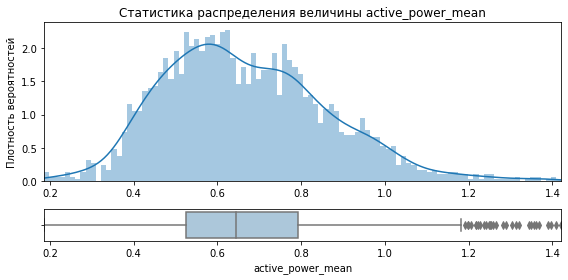

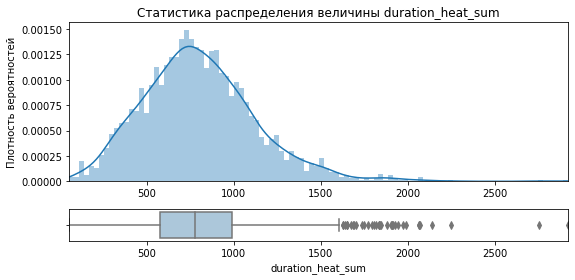

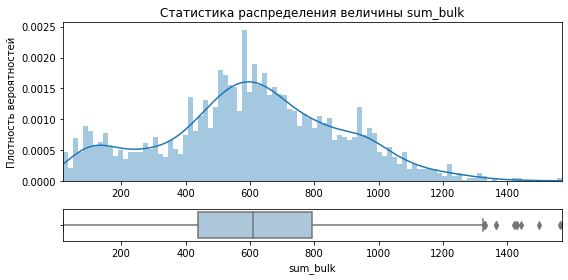

data type count passes count duplicates average_truncated  \
active_power_mean   float64            0                0              0.66   
duration_heat_sum     int64            0                0            785.22   
sum_bulk            float64            0                0            608.86   

                    count    mean     std   min     25%    50%    75%     max  \
active_power_mean  2322.0    0.67     0.2  0.19    0.53   0.64   0.79    1.42   
duration_heat_sum  2322.0  802.94  326.49  57.0  580.25  777.0  991.0  2919.0   
sum_bulk           2322.0  607.46  281.46  19.0  438.25  608.5  794.0  1569.0   

                  emissions  
active_power_mean        29  
duration_heat_sum        37  
sum_bulk                 11

In [39]:
# Исследование распределения признаков 'active_power_mean','duration_heat_sum','sum_bulk'
for col in ['active_power_mean','duration_heat_sum','sum_bulk']:
    val_min = df_full[col].min()
    val_max = df_full[col].max()
    basic_statistics_numerical_features_(
        data=df_full[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )
pd.DataFrame(dataframe_summary(df_full[['active_power_mean','duration_heat_sum','sum_bulk']])).T

Оценка центрального положения признаков `'active_power_mean'`, `'duration_heat_sum'` и `'sum_bulk'` характеризуются небольшой правосторонней скошенностью, медианное и среднее значение отличаются на 0.2-4.5%. Оценка вариабельности выборки показывает заметные отличия размаха диапазона значений хвостов выборки 25%-min и max-75% соответствует 0.34/0.63, 523/2142 и 419/775, что так же свидетельствует о наличии правосторонней асимметрии. Размах выборок в 4.7, 7 и 4.4 раза больше интерквантильного размаха, что говорит о наличии заметного числа выбросов.

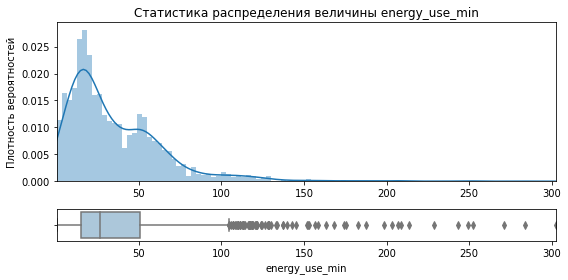

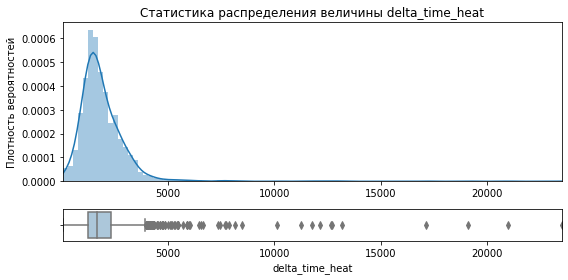

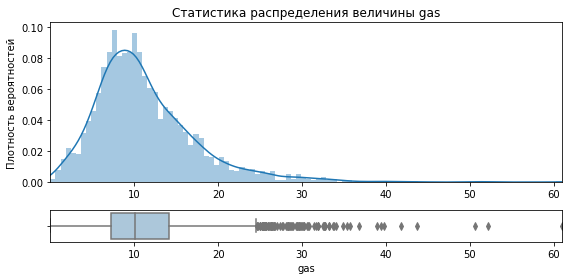

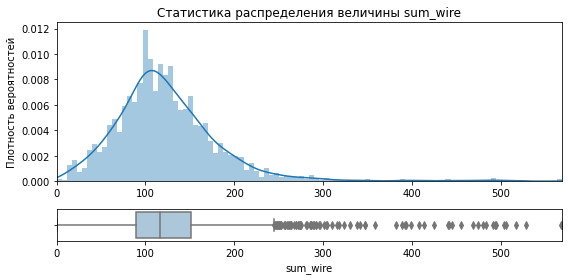

data type count passes count duplicates average_truncated  \
energy_use_min    float64            0                0              31.4   
delta_time_heat   float64            0                0            1772.5   
gas               float64            0                0             10.63   
sum_wire          float64            0                0            118.87   

                  count    mean      std   min     25%     50%      75%  \
energy_use_min   2322.0   35.98    31.41  0.33   15.03   26.61    50.84   
delta_time_heat  2322.0  1921.0  1329.05  64.0  1267.0  1678.0  2332.75   
gas              2322.0    11.3     6.16  0.01    7.27   10.09    14.17   
sum_wire         2322.0  124.73    63.13   0.0   88.78  116.01    151.3   

                     max emissions  
energy_use_min    302.46        83  
delta_time_heat  23485.0        74  
gas                60.94        89  
sum_wire          568.78        81

In [40]:
# Исследование распределения признаков 'energy_use_min','delta_time_heat','gas','sum_wire'
for col in ['energy_use_min','delta_time_heat','gas','sum_wire']:
    val_min = df_full[col].min()
    val_max = df_full[col].max()
    basic_statistics_numerical_features_(
        data=df_full[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )
pd.DataFrame(dataframe_summary(df_full[['energy_use_min','delta_time_heat','gas','sum_wire']])).T

Оценка центрального положения признаков `'energy_use_min'`, `'delta_time_heat'`, `'gas'` и `'sum_wire'` характеризуются сильной правосторонней скошенностью, медианное и среднее значение отличаются сильно (7-26%). Оценка вариабельности выборки показывает заметные отличия размаха диапазона значений хвостов выборки 25%-min и max-75% соответствует 15/252, 1203/21152, 7/47 и 89/417, что так же свидетельствует о наличии сильной правосторонней асимметрии. Размах выборок в 8, 22, 9 и 9 раза больше интерквантильного размаха, что говорит о наличии заметного числа выбросов, а в отношении признака `'delta_time_heat'` очень сильно выражены.

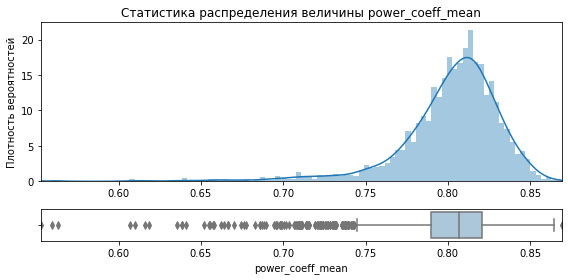

data type count passes count duplicates average_truncated  \
power_coeff_mean   float64            0                0              0.81   

                   count mean   std   min   25%   50%   75%   max emissions  
power_coeff_mean  2322.0  0.8  0.03  0.55  0.79  0.81  0.82  0.87       113

In [41]:
# Исследование распределения признаков 'power_coeff_mean'
for col in ['power_coeff_mean']:
    val_min = df_full[col].min()
    val_max = df_full[col].max()
    basic_statistics_numerical_features_(
        data=df_full[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )
pd.DataFrame(dataframe_summary(df_full[['power_coeff_mean']])).T

Оценка центрального положения признака `'power_coeff_mean'` характеризуются сильной левосторонней скошенностью, при этом медианное и среднее значение отличаются минимально. Оценка вариабельности показывает отличия размаха диапазона значений хвостов выборки 25%-min=0.24 и max-75%=0.05, что так же свидетельствует о наличии сильной асимметрии. Размах выборок в 11 раз больше интерквантильного размаха, что говорит о наличии заметного числа выбросов.

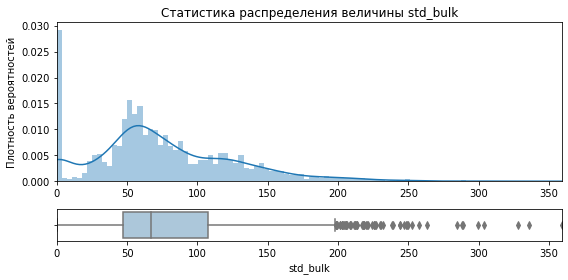

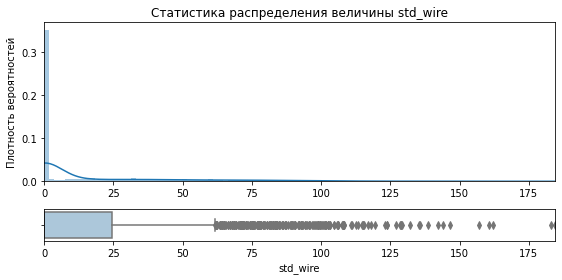

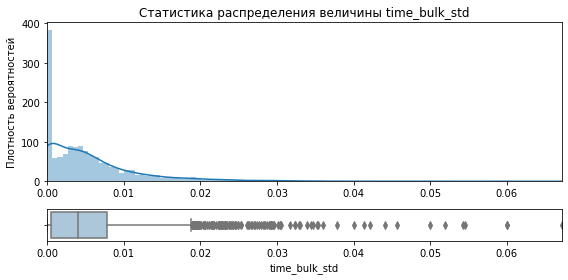

data type count passes count duplicates average_truncated   count  \
std_bulk   float64            0              173             73.18  2322.0   
std_wire   float64            0              173              9.74  2322.0   

          mean    std  min    25%    50%     75%     max emissions  
std_bulk  76.8   51.7  0.0  47.04  67.18  107.48  358.83        61  
std_wire  16.8  29.95  0.0    0.0    0.0    24.7  184.54       255

In [42]:
# Исследование распределения признаков 'std_bulk','std_wire','time_bulk_std'
for col in ['std_bulk','std_wire','time_bulk_std']:
    val_min = df_full[col].min()
    val_max = df_full[col].max()
    basic_statistics_numerical_features_(
        data=df_full[col], bins=100, set_lim=[val_min, val_max], 
        title=f'Статистика распределения величины {col}',
        xlabel=col, 
    )
pd.DataFrame(dataframe_summary(df_full[['std_bulk','std_wire']])).T

Исследуемые признаки `'std_bulk'`, `'std_wire'` и `'time_bulk_std'`  характеризуют дисперсию разброса значений в таблицах `data_bulk`, `'data_wire'` и `'data_bulk_time'`. Наличие большого пика нулевых значений объясняется присутствием в признаках большого числа единичные значений у наблюдений, у которых естественно дисперсии не существует. При этом признак `'data_bulk_time'` приведёт к синусоидальному распрелеоению для учёта цикличных свойств его значений.

Оценка центрального положения признаков `'std_bulk'`, `'std_wire'` и `'time_bulk_std'` характеризуются очень сильной правосторонней скошенностью. Оценка вариабельности выборки показывает заметные отличия размаха диапазона значений хвостов выборок 25%-min и max-75% соответствует 47/251, 0/159 и 0/0.06, что так же свидетельствует о наличии сильной правосторонней асимметрии. Размах выборок в 6, 7 и 7 раза больше интерквантильного размаха, что говорит о наличии заметного числа выбросов.

#### **2.9.2. Корреляционный анализ данных**

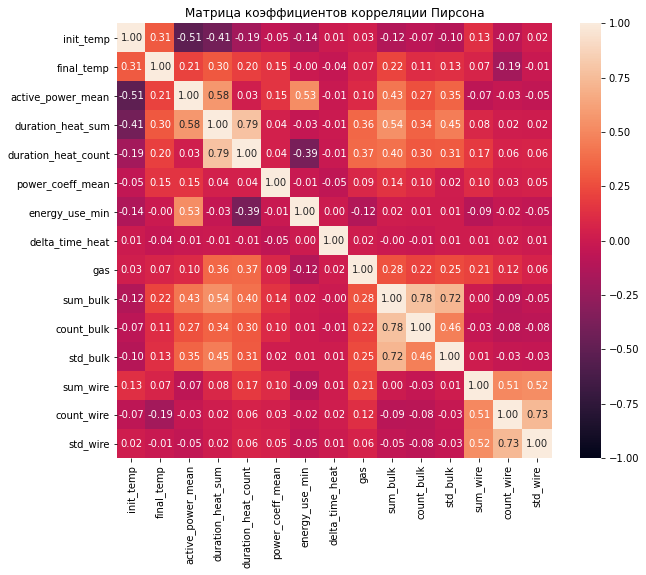

In [43]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_full.corr(), vmin=-1, vmax=1, square=True, annot=True, fmt='.2f');
plt.title('Матрица коэффициентов корреляции Пирсона')
plt.show()

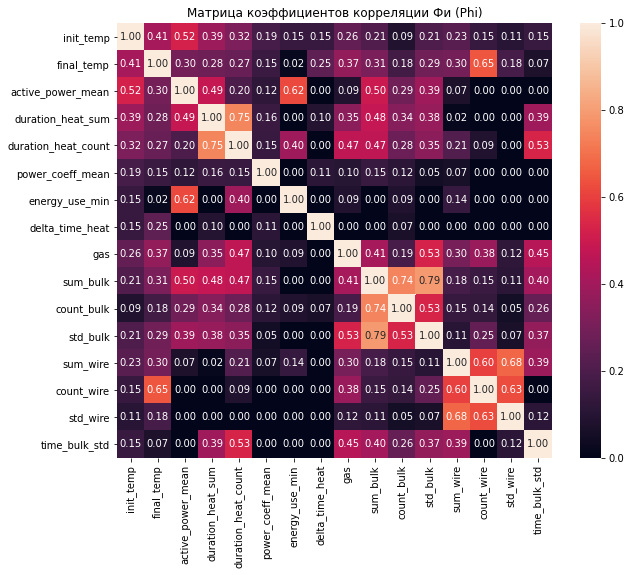

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
phik_matrix = df_full.phik_matrix(interval_cols=df_full.columns)
sns.heatmap(phik_matrix, vmin=0, vmax=1, square=True, annot=True, fmt='.2f')
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

Из всех сгенерированных признаков, были исключены все мультиколлиниарные с величиной отсечения по коэффициенту корреляции 0.8. В получившемся дата фрейме наибольшая корреляция наблюдается между производными одного признака. Отметим явную обратную корреляцию между начальной температурой и величинами, отражающими затраченную энергию на процесс, что объясняется необходимостью большего подогрева обрабатываемого материала. Такая же обратная зависимость между количеством циклов нагревания и минимальной затраченной энергией на прогрев материала. Сильный коэффициент Фи (0.65) наблюдается между конечной температурой и количеством введения легирующего материала, что видимо, объясняется необходимостью держать относительно высокие температуры при легировании стали и недопущения кристаллизации материала.

### **2.10. Вывод**

1. Данные об электродах 'data_arc' показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки. Было создано 5 дополнительных признаков:
    - длительность нагрева `'duration_heat'`;
    - полная мощность `'full_power'`;
    - коэффициент мощности `'power_coeff'`;
    - энергопотребление `'energy_use'`;
    - длительность между первым и последним циклом нагрева `'delta_time_heat'`.
    
    А также сгенерированы агрегированные значения признаков: mean, std, min, max, count. Все признаки характеризуются сильной правосторонней или левосторонней асимметрией с наличием большого числа выбросов.
2. Данные о продувке сплава газом 'data_gas' характеризуются правосторонней асимметрией с наличием большого числа выбросов.
3. Данные об изменениях температуры 'data_temp' показали шести аномальных температуры (ниже 1500 гдад), которые были исправлены на следующее адекватное в ряду. Начальное значение температуры выбрано за признак, конечное значение температуры выбрано в качестве целевого значения. Основное количество циклов нагрева для каждой партии `'duration_heat_count'` находится в диапазоне 4-7 раз (83% наблюдений), при этом наиболее редкими событиями являются 10 и более раз (0.6% наблюдений).
4. Данные об объёме сыпучих материалов 'data_bulk' показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки. Признаки характеризуются большим разнообразием частот количества значений 1-2805, в следствии чего можно наблюдать пропуски в диапазоне 99.9-10.4%. Наибольшая частота обработак сыпучими материалами (88% всего количества) происходит на 3, 4, 12, 14 и 15 цикла, что соответствует 94% всего объёма материала. По объёмам используемого материала наиболее частыми можно отметить значения, распределение которых концентрируется вокруг 100, 150, 200, 250, 300 и 400. Основное количество циклов обработки сыпучими материалами для каждой партии `'count_bulk'` находится в диапазоне 4-6 раз (79% наблюдений), при этом наиболее редкими событиями являются 6 и более раз (2.2% наблюдений).
5. Данные о времени подачи сыпучих материалов 'data_bulk_time' показали шести аномальных партий, в которых отмечена аномально высокая временная дисперсия подачи материала, выявленные партии были исключены из анализа. Направление движения времени подачи сыпучих материалов идёт в противоположном направлении от обозначенного порядка признаков - данное свойство не описано в задании проекта. Часто в одних и тех же наблюдениях встречаются ряды с одинаковыми значениями времени в разные циклы обработки, данное явление невозможно физически, либо подразумевается некоторое иное технологическое явление, однако указаний на это в описании проекта отсутствует, поэтому эти данные решено оставить. У 14% наблюдений нарушается равномерный порядок изменения значений времени, если исходить из того, что данные о времени даны точные, то случаи, когда нарушается равномерный порядок изменения ряда, может свидетельствовать о переходе технологического процесса на следующие сутки или ошибке внесения данных.
6. Данные об объёме проволочных материалов 'data_wire'. Основное количество обработок происходит на первой и второй итерации (95% всего количества и объёма соответственно), в следствии чего основная доля пропусков наблюдается во всех остальных признаках 97.6-99.9%. По объёмам используемого материала наиболее частые значения находятся в диапазоне 0-300 с пиком плотности вероятности на 100. Основное количество циклов добавления легирующих материалов для каждой партии `'count_wire'` находится в диапазоне 2-3 раза (98% наблюдений), при этом наиболее редкими событиями являются 1 и 4 и более раз (0.3% наблюдений)
7. Данные о времени подачи проволочных материалов 'data_wire_time' показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки.
8. Для обучения моделей оставлены признаки с величиной отсечения по коэффициенту корреляции 0.8. В получившемся дата фрейме наибольшая корреляция наблюдается между производными одного признака. Отметим явную обратную корреляцию между начальной температурой и величинами, отражающими затраченную энергию на процесс, что объясняется необходимостью большего подогрева обрабатываемого материала. Такая же обратная зависимость между количеством циклов нагревания и минимальной затраченной энергией на прогрев материала. Сильный коэффициент Фи (0.65) наблюдается между конечной температурой и количеством введения легирующего материала, что видимо, объясняется необходимостью держать относительно высокие температуры при легировании стали и недопущения кристаллизации материала.

In [45]:
# Очистка памяти
del array, ax, bulk_time_std, case_ids, col, connection_string, data, data_arc, data_bulk, data_bulk_time, \
    data_gas, data_wire, data_wire_time, db_config, df, df_temp, engine_cloud, f, features_drop, fig, filtr_ind, \
    i, layout, n, phik_matrix, val_max, val_min, wire_time_std

## **3. Обучение моделей**

In [46]:
# Список зипланированных к использованию методов
scaler_type = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    MaxAbsScaler()
]
models_type = [
    ('ridge', Ridge()),
    ('lasso', Lasso(random_state=RANDOM_STATE)),
    ('elasticnet', ElasticNet(random_state=RANDOM_STATE)),
    ('DecisionTree', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ('lineartree', LinearTreeRegressor(base_estimator=LinearRegression())),
    ('linearboost', LinearBoostRegressor(base_estimator=LinearRegression(), random_state=RANDOM_STATE)),
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_STATE, verbosity=0, tree_method='gpu_hist', predictor='gpu_predictor')),
    ('lgbm', lgb.LGBMRegressor(verbosity=-1, random_state=RANDOM_STATE)),
    ('gradientboosting', HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
    ('catboost', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, task_type='GPU', devices='0:1')),
    ('random_forest', RandomForestRegressor(random_state=RANDOM_STATE)),
]
scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'r2_score': make_scorer(r2_score)
}

### **3.1. Подготовка данных**

In [47]:
# Разбиение данных на train/test
X_train, X_test, Y_train, Y_test = train_test_split(df_full.drop('final_temp', axis=1), df_full['final_temp'], test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

print('Размеры выборок:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Безлайновая оценка моделей
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    for name, model in models_type:
        metrix = 1000
        pip_scaler = None
        pip_name = None
        for scaler in scaler_type:
            pipeline = Pipeline([('scaler', scaler), ('model', model)])
            scores = np.mean(cross_validate(estimator=pipeline, X=X_train.values, y=Y_train, scoring=scoring, cv=3)['test_mean_squared_error'])
            if scores < metrix:
                metrix = scores
                pip_scaler = scaler
                pip_name = name
        print(np.round(metrix,2), pip_scaler, pip_name)

Размеры выборок: (1741, 15) (581, 15) (1741,) (581,)


| Модели регрессии              | Scaler         |  MAE  |
| ----------------------------- | -------------- | ----- |
| Ridge                         | StandardScaler | 66.04 |
| Lasso                         | StandardScaler | 80.74 |
| ElasticNet                    | StandardScaler | 87.9  |
| DecisionTreeRegressor         | StandardScaler | 151.0 |
| LinearTreeRegressor           | StandardScaler | 70.42 |
| LinearBoostRegressor          | RobustScaler   | 69.87 |
| XGBRegressor                  | RobustScaler   | 81.49 |
| LGBMRegressor                 | MaxAbsScaler   | 74.99 |
| HistGradientBoostingRegressor | StandardScaler | 76.69 |
| CatBoostRegressor             | MinMaxScaler   | 68.61 |
| RandomForestRegressor         | MinMaxScaler   | 76.87 |

Наиболее интересные результаты показывают линейные модели Ridge, а так же LinearBoostRegressor и бустинговая модель CatBoostRegressor.

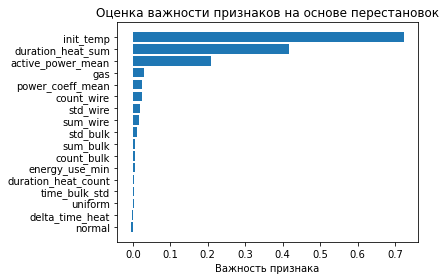

In [48]:
# Оценка важности признаков на основе перестановок
X_train_perm = X_train.copy()
X_test_perm = X_test.copy()

# Нормализация числовых признаков
scaler = MinMaxScaler().fit(X_train_perm)
X_train_perm = pd.DataFrame(scaler.transform(X_train_perm), columns=X_train.columns)
X_test_perm = pd.DataFrame(scaler.transform(X_test_perm), columns=X_train.columns)

# Добавляем случайные признаки с равномерным и нормальным распределениями
X_train_perm['uniform'] = np.random.uniform(-1, 1, len(X_train_perm))
X_train_perm['normal'] = np.random.normal(-1, 1, len(X_train_perm))
X_test_perm['uniform'] = np.random.uniform(-1, 1, len(X_test_perm))
X_test_perm['normal'] = np.random.normal(-1, 1, len(X_test_perm))

model = CatBoostRegressor(
    iterations=1013,
    learning_rate=0.04727087473073797,
    depth=3,
    l2_leaf_reg=2.1859110889969595,
    border_count=359,
    feature_border_type='Uniform',
    counter_calc_method=None,
    random_strength=0.9028654680911469,
    bagging_temperature=1.0487049307369318,
    fold_len_multiplier=3.7226562893192403,
    score_function='Cosine',
    leaf_estimation_backtracking='AnyImprovement',
    penalties_coefficient=0.6880239758683481,
    langevin=False,
    eval_metric='MAE',
    verbose=False,
    leaf_estimation_method=None,
    bootstrap_type='Bayesian', 
    loss_function='RMSE', 
    subsample=None,
    od_type='Iter',
    od_pval=None,
    od_wait=60,
    random_state=RANDOM_STATE,
)
model.fit(X_train_perm, Y_train)

result = permutation_importance(model, X_test_perm, Y_test, n_repeats=500, random_state=RANDOM_STATE)
sorted_idx = result.importances_mean.argsort()
plt.barh(X_train_perm.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Важность признака')
plt.title('Оценка важности признаков на основе перестановок')
plt.tight_layout()
plt.show()

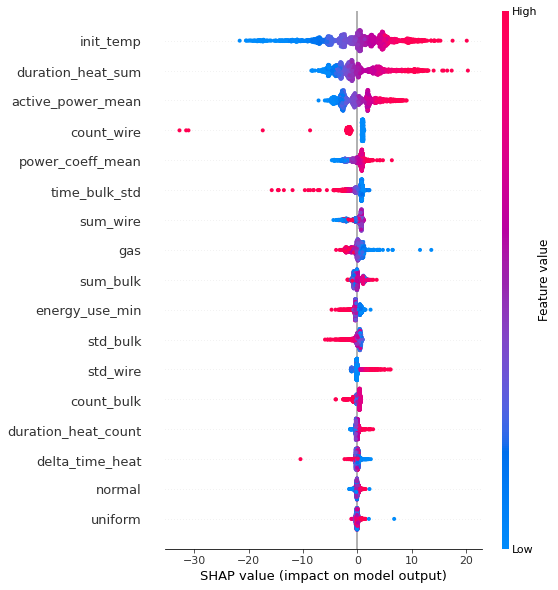

In [49]:
# Выполним оценку значимости признаков используя shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_perm)
shap.summary_plot(explainer.shap_values(X_train_perm), X_train_perm)

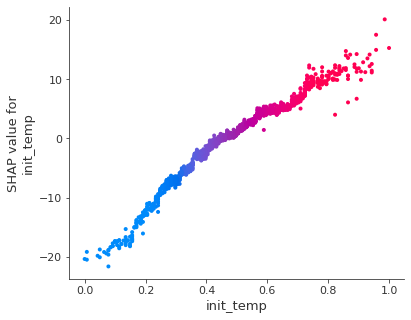

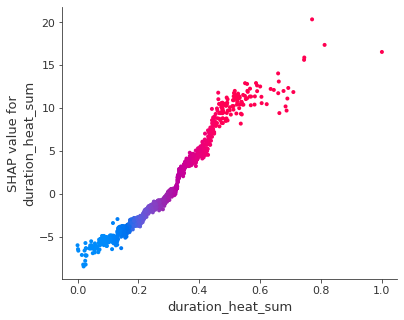

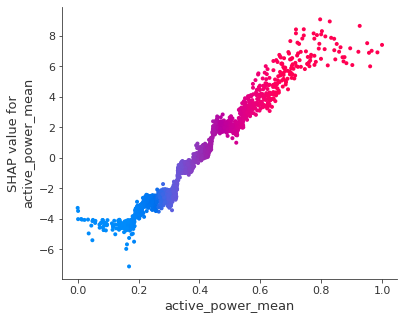

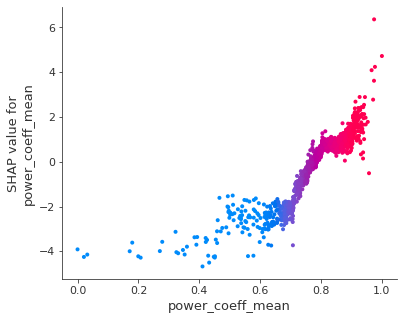

In [50]:
for col in ['init_temp','duration_heat_sum','active_power_mean','power_coeff_mean']:
    shap.dependence_plot(col, shap_values, X_train_perm, interaction_index=col)
    plt.show()

Наиболее значимыми признаками являются `'init_temp'`, `'duration_heat_sum'`, `''power_coeff_mean''` и `'active_power_mean'` которые по своей сути отражают начальные параметры системы и количество переданной ей энергии, поэтому данные признаки наиболее значимо влияют на прогнозирование конечной температуры, чем выше значения указанных признаков, тем более высокая температура будет прогнозироваться.

Остальные признаки вносят по большей части вспомогательный характер и имеют меньшее влияние на таргет.

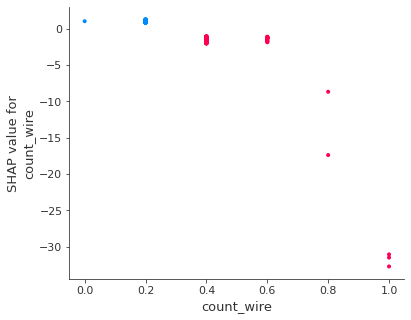

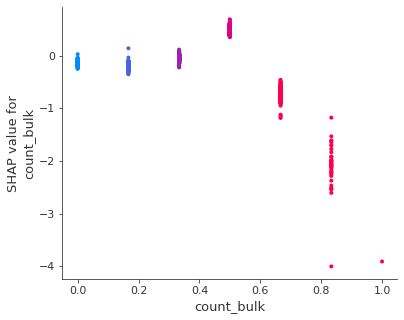

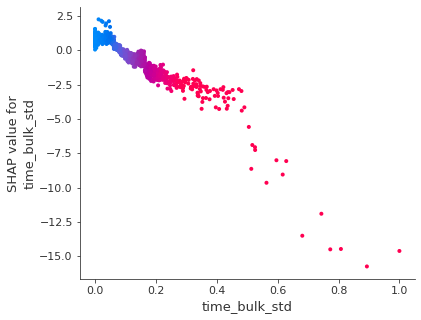

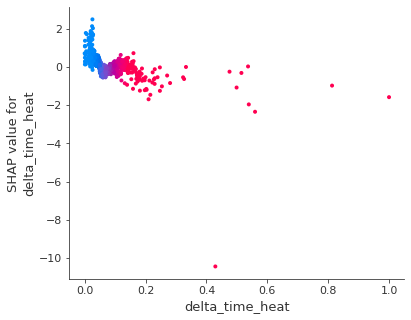

In [51]:
for col in ['count_wire','count_bulk','time_bulk_std','delta_time_heat']:
    shap.dependence_plot(col, shap_values, X_train_perm, interaction_index=col)
    plt.show()

Признаки `'count_wire'`, `'count_bulk'`, `'time_bulk_std'` и `'delta_time_heat'` временной характер технологических процессов, которые оказывают влияние на целевой признак. Мы видим, что чем меньшее количество операций производится и чем более они короткие, тем более высокие значения целевого признака можно прогнозировать.

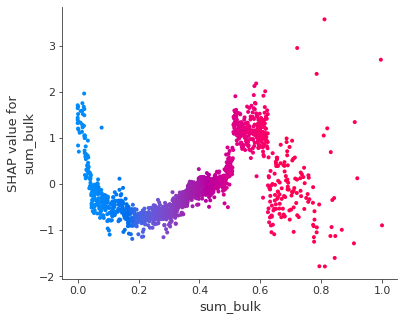

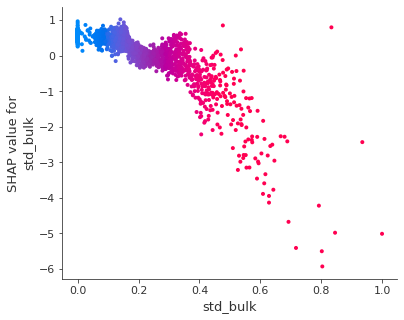

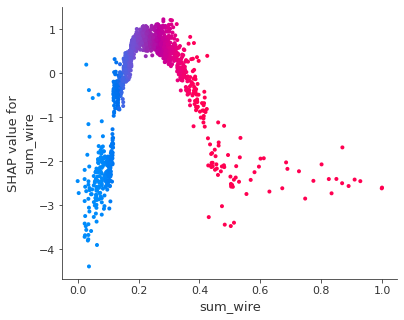

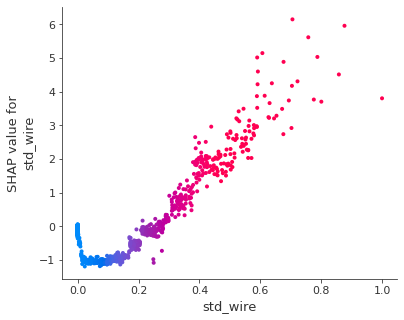

In [52]:
for col in ['sum_bulk','std_bulk','sum_wire','std_wire']:
    shap.dependence_plot(col, shap_values, X_train_perm, interaction_index=col)
    plt.show()

Признаки `'sum_bulk'`,`'std_bulk'`,`'sum_wire'` и `'std_wire'` характеризует количество дополнительного материала, добавленного в партию. На графиках можно отметить по большей части нелинейные взаимодействия. Скорей всего это связанно не только с изменением объёмов материала и как следствие температурных характеристик. Следует учесть, что эти материалы являются реагентами, и значит могут вступают в реакции как с выделением тепла, так и с поглощением, что невозможно учесть, не зная какой именно материал добавляется в расплав. Так же при добавлении реагентов, происходит выделение газов и шлака. который удаляется и этот факт так же никак не обозначен, хотя по всей видимости будет иметь довольно значимое влияние на конечную температуру.

### **3.2. Исследование перспективных моделей**

In [53]:
# Подбор оптимальных гиперпараметров для Ridge
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            if trial.suggest_categorical('iter', [True, False]):
                max_iter = trial.suggest_int('max_iter', 100, 3000)
            else:
                max_iter = None

            model = Ridge(
                random_state=RANDOM_STATE, 
                max_iter=max_iter,
                alpha=trial.suggest_float('alpha', 0.01, 200),
                fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
                solver=trial.suggest_categorical('solver', ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']),
                tol=trial.suggest_float('tol', 1e-10, 1e-4),
            )
            pipeline = Pipeline([
                ('scaler', scaler_type[trial.suggest_int('scaler_type', 0, 3)]),
                ('polinom', PolynomialFeatures(
                    degree=2,
                    interaction_only=trial.suggest_categorical('interaction_only', [True, False]),
                    include_bias=trial.suggest_categorical('include_bias', [True, False]),
                )),
                ('drop_corr', DropCorrelatedFeatures(
                    threshold=trial.suggest_float('drop_corr_threshold', 0.0, 0.8),
                    method=trial.suggest_categorical('drop_corr_method', ['pearson','spearman']),
                )),
                ('drop_constant', DropConstantFeatures(
                    tol=trial.suggest_float('drop_constant_tol', 0.0, 1.0),
                )),
                ('classifier', model)
            ])
            scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)
            mae_scores = scores['test_mean_absolute_error']

            return st.t.interval(confidence=0.95, df=(len(mae_scores) - 1), loc=np.mean(mae_scores), scale=np.std(mae_scores))[1]
        except:
            raise optuna.TrialPruned()
    
    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                study_name='Ridge', storage='sqlite:///my_study_Ridge.db', load_if_exists=True
                                )
    study.optimize(objective, n_trials=5000, timeout=None, n_jobs=-1)
    
else: # Валидирование модели Ridge
    print('''
    Количество завершенных испытаний: 5000
    Лучшее испытание завершено на итерации: 3681
    Лучшее значение целевой метрики: 6.152888796541882
    ''')
    model = Ridge(
        random_state=RANDOM_STATE, 
        max_iter=2523,
        alpha=74.53967323435674,
        fit_intercept=True,
        solver='cholesky',
        tol=5.476823053079309e-05,
    )
    pipeline = Pipeline([
        ('scaler', scaler_type[0]),
        ('polinom', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
        ('drop_corr', DropCorrelatedFeatures(threshold=0.7872936599774298, method='pearson')),
        ('drop_constant', DropConstantFeatures(tol=0.6372355066014503)),
        ('classifier', model)
    ])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

    print('Матрика MAE:', np.round(np.mean(scores['test_mean_absolute_error']),3))
    print('Значение R2:', np.round(np.mean(scores['test_r2_score']),3))


    Количество завершенных испытаний: 5000
    Лучшее испытание завершено на итерации: 3681
    Лучшее значение целевой метрики: 6.152888796541882
    
Матрика MAE: 6.113
Значение R2: 0.464


In [54]:
# Подбор оптимальных гиперпараметров для LinearBoostRegressor
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            if trial.suggest_categorical('depth', [True, False]):
                max_depth=trial.suggest_int('max_depth', 1, 100)
            else:
                max_depth=None

            if trial.suggest_categorical('leaf_nodes', [True, False]):
                max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, int(X_train.shape[0]/X_train.shape[1]))
            else:
                max_leaf_nodes=None

            model = LinearBoostRegressor(
                random_state=RANDOM_STATE,
                base_estimator=LinearRegression(), 
                loss=trial.suggest_categorical('loss', ['linear','squared_error','absolute_error','huber']),
                n_estimators=trial.suggest_int('n_estimators', 1, 100),
                max_depth=max_depth,
                min_samples_split=trial.suggest_int('min_samples_split', 1, 100),
                min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
                min_weight_fraction_leaf=trial.suggest_float('min_weight_fraction_leaf', 0, 1.0),
                max_features=trial.suggest_categorical('max_features', [None,'auto','sqrt','log2']),
                max_leaf_nodes=max_leaf_nodes,
                min_impurity_decrease=trial.suggest_float('min_impurity_decrease', 0.0, 100.0),
                ccp_alpha=trial.suggest_float('ccp_alpha', 0.0, 100.0)
            )
            pipeline = Pipeline([
                ('scaler', scaler_type[trial.suggest_int('scaler_type', 0, 3)]),
                ('polinom', PolynomialFeatures(
                    degree=2,
                    interaction_only=trial.suggest_categorical('interaction_only', [True, False]),
                    include_bias=trial.suggest_categorical('include_bias', [True, False]),
                )),
                ('drop_corr', DropCorrelatedFeatures(
                    threshold=trial.suggest_float('drop_corr_threshold', 0.0, 0.8),
                    method=trial.suggest_categorical('drop_corr_method', ['pearson','spearman']),
                )),
                ('drop_constant', DropConstantFeatures(
                    tol=trial.suggest_float('drop_constant_tol', 0.0, 1.0),
                )),
                ('classifier', model)
            ])
            scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)
            mae_scores = scores['test_mean_absolute_error']

            return st.t.interval(confidence=0.95, df=(len(mae_scores) - 1), loc=np.mean(mae_scores), scale=np.std(mae_scores))[1]
        except:
            raise optuna.TrialPruned()
    
    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                study_name='LinearBoostRegressor', storage='sqlite:///my_study_LinearBoostRegressor.db', load_if_exists=True
                                )
    study.optimize(objective, n_trials=2700, timeout=None, n_jobs=6)
    
else: # Валидирование модели LinearBoostRegressor
    print('''
Количество завершенных испытаний: 5000
Лучшее испытание завершено на итерации: 3691
Лучшее значение целевой метрики: 6.27092079582046
''')
    model = LinearBoostRegressor(
        base_estimator=LinearRegression(), 
        loss='linear',
        n_estimators=97,
        max_depth=None,
        min_samples_split=32,
        min_samples_leaf=53,
        min_weight_fraction_leaf=0.11528450719758059,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        max_leaf_nodes=None,
        min_impurity_decrease=95.55868946724772,
        ccp_alpha=43.801194650575056
    )
    pipeline = Pipeline([
        ('scaler', scaler_type[0]),
        ('polinom', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
        ('drop_corr', DropCorrelatedFeatures(threshold=0.7174018938214423, method='spearman')),
        ('drop_constant', DropConstantFeatures(tol=0.7917093877241319)),
        ('classifier', model)
    ])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

    print('Значение MAE:', np.round(np.mean(scores['test_mean_absolute_error']),3))
    print('Значение R2:', np.round(np.mean(scores['test_r2_score']),3))


Количество завершенных испытаний: 5000
Лучшее испытание завершено на итерации: 3691
Лучшее значение целевой метрики: 6.27092079582046

Значение MAE: 6.225
Значение R2: 0.441


In [55]:
# Подбор оптимальных гиперпараметров для CatBoostRegressor
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            od_type=trial.suggest_categorical('od_type', [None,'Iter','IncToDec'])
            od_pval=None
            od_wait=None
            if od_type == 'Iter':
                od_wait=trial.suggest_int('od_wait', 20, 100)
            elif od_type == 'IncToDec':
                od_pval=trial.suggest_float('od_pval', 1e-10, 1e-2)

            loss_function=trial.suggest_categorical('loss_function', ['RMSE','MAE','Quantile','LogLinQuantile','MAPE','Poisson'])
            leaf_estimation_method=None
            if loss_function == 'MAE' or loss_function == 'Quantile':
                leaf_estimation_method='Gradient'

            bootstrap_type=trial.suggest_categorical('bootstrap_type', [None,'Bayesian','MVS','Poisson'])
            subsample=None 
            if bootstrap_type == 'Poisson' or bootstrap_type == 'Bernoulli' or bootstrap_type == 'MVS':
                subsample=trial.suggest_float('subsample', 0.1, 1)
            
            model = CatBoostRegressor(
                iterations=trial.suggest_int('iterations', 100, 3000),
                learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.1),
                depth=trial.suggest_int('depth', 1, 10, step=1),
                l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.001, 100, log=True),
                border_count=trial.suggest_int('border_count', 155, 405),
                feature_border_type=trial.suggest_categorical('feature_border_type', [None,'GreedyLogSum','Uniform','Median','MaxLogSum','MinEntropy']),
                counter_calc_method=trial.suggest_categorical('counter_calc_method', [None,'SkipTest']),
                random_strength=trial.suggest_float('random_strength', 0., 1),
                bagging_temperature=trial.suggest_float('bagging_temperature', 0., 4),
                fold_len_multiplier=trial.suggest_float('fold_len_multiplier', 1, 6),
                score_function=trial.suggest_categorical('score_function', [None,'L2','Cosine']),
                leaf_estimation_backtracking=trial.suggest_categorical('leaf_estimation_backtracking', [None,'AnyImprovement','Armijo']),
                penalties_coefficient=trial.suggest_float('penalties_coefficient', 0., 2),
                langevin=trial.suggest_categorical('langevin', [True,False]),
                eval_metric='MAE',
                verbose=False,
                leaf_estimation_method=leaf_estimation_method,
                bootstrap_type=bootstrap_type, 
                loss_function=loss_function, 
                subsample=subsample,
                od_type=od_type,
                od_pval=od_pval,
                od_wait=od_wait,
                random_state=RANDOM_STATE,
            )
            pipeline = Pipeline([
                ('scaler', scaler_type[trial.suggest_int('scaler_type', 0, 3)]),
                ('polinom', PolynomialFeatures(
                    degree=2,
                    interaction_only=trial.suggest_categorical('interaction_only', [True, False]),
                    include_bias=trial.suggest_categorical('include_bias', [True, False]),
                )),
                ('drop_corr', DropCorrelatedFeatures(
                    threshold=trial.suggest_float('drop_corr_threshold', 0.0, 0.8),
                    method=trial.suggest_categorical('drop_corr_method', ['pearson','spearman']),
                )),
                ('drop_constant', DropConstantFeatures(
                    tol=trial.suggest_float('drop_constant_tol', 0.0, 1.0),
                )),
                ('classifier', model)
            ])
            scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)
            mae_scores = scores['test_mean_absolute_error']

            return st.t.interval(confidence=0.95, df=(len(mae_scores) - 1), loc=np.mean(mae_scores), scale=np.std(mae_scores))[1]
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                study_name='CatBoostRegressor', storage='sqlite:///my_study_CatBoostRegressor.db', load_if_exists=True
                                )
    study.optimize(objective, n_trials=10, timeout=None, n_jobs=6)
    
else: # Валидирование модели CatBoostRegressor
    print('''
Количество завершенных испытаний: 5000
Лучшее испытание завершено на итерации: 4530
Лучшее значение целевой метрики: 6.062272606232743
''')
    model = CatBoostRegressor(
        iterations=1013,
        learning_rate=0.04727087473073797,
        depth=3,
        l2_leaf_reg=2.1859110889969595,
        border_count=359,
        feature_border_type='Uniform',
        counter_calc_method=None,
        random_strength=0.9028654680911469,
        bagging_temperature=1.0487049307369318,
        fold_len_multiplier=3.7226562893192403,
        score_function='Cosine',
        leaf_estimation_backtracking='AnyImprovement',
        penalties_coefficient=0.6880239758683481,
        langevin=False,
        eval_metric='MAE',
        verbose=False,
        leaf_estimation_method=None,
        bootstrap_type='Bayesian', 
        loss_function='RMSE', 
        subsample=None,
        od_type='Iter',
        od_pval=None,
        od_wait=60,
        random_state=RANDOM_STATE,
    )
    pipeline = Pipeline([
        ('scaler', scaler_type[1]),
        ('polinom', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
        ('drop_corr', DropCorrelatedFeatures(threshold=0.6050438286834446, method='pearson')),
        ('drop_constant', DropConstantFeatures(tol=0.745447236590603)),
        ('classifier', model)
    ])
    scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=5)

    print('Значение MAE:', np.round(np.mean(scores['test_mean_absolute_error']),3))
    print('Значение R2:', np.round(np.mean(scores['test_r2_score']),3))


Количество завершенных испытаний: 5000
Лучшее испытание завершено на итерации: 4530
Лучшее значение целевой метрики: 6.062272606232743

Значение MAE: 6.018
Значение R2: 0.475


In [56]:
# Функции для работы нейронной сети
def building_nn_architecture_(list_neurons, activ_funct, list_batch_norm, last_af):
    '''Построение архитектуры нейронной сети'''
    net_layers = [] # Архетектура сети
    for i in range(1, len(list_neurons) - 1): # Создаём список с архитектурой сети
        net_layers.append(nn.Linear(list_neurons[i-1], list_neurons[i]))
        net_layers.append(list_batch_norm[i-1])
        net_layers.append(activ_funct[i-1])
    net_layers.append(nn.Linear(list_neurons[-2], list_neurons[-1]))
    net_layers.append(last_af)
    return nn.Sequential(*net_layers) # Инициализируем MLP

a_f = {
    'sigmoid': nn.Sigmoid(),
    'relu': nn.ReLU(),
    'prelu': nn.PReLU(),
    'tanh': nn.Tanh(),
    'elu': nn.ELU(),
    'identity': nn.Identity(),
    'leaky_relu': nn.LeakyReLU(),
    'softplus': nn.Softplus(),
    'selu': nn.SELU()
}
list_fa = list(a_f.keys())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
# Подбор архитектуры нейронной сети
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        
        num_epochs = trial.suggest_int('num_epochs', 800, 800) # Задаём количество эпох
        max_neurons = trial.suggest_int('max_neurons', 500, 500) # Задаём максимальное значение количества нейронов в слое

        scores = []
        epohs = []
        cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
        for train_ind, test_ind in cv.split(X_train, Y_train):

            X_cv_train, Y_cv_train = X_train.iloc[train_ind], Y_train.iloc[train_ind]
            X_cv_test, Y_cv_test = X_train.iloc[test_ind], Y_train.iloc[test_ind]

            pipeline = Pipeline([
                ('scaler', scaler_type[trial.suggest_int('scaler_type', 0, 3)]),
                ('polinom', PolynomialFeatures(
                    degree=2,
                    interaction_only=trial.suggest_categorical('interaction_only', [True, False]),
                    include_bias=trial.suggest_categorical('include_bias', [True, False]),
                )),
                ('drop_corr', DropCorrelatedFeatures(
                    threshold=trial.suggest_float('drop_corr_threshold', 0.0, 0.8),
                    method=trial.suggest_categorical('drop_corr_method', ['pearson','spearman']),
                )),
                ('drop_constant', DropConstantFeatures(
                    tol=trial.suggest_float('drop_constant_tol', 0.0, 1.0),
                )),
            ])
            X_cv_train, Y_cv_train = pipeline.fit_transform(X_cv_train), Y_cv_train
            X_cv_test, Y_cv_test = pipeline.transform(X_cv_test), Y_cv_test

            X_cv_train, Y_cv_train = torch.FloatTensor(X_cv_train.values), torch.FloatTensor(Y_cv_train.values)
            X_cv_test, Y_cv_test = torch.FloatTensor(X_cv_test.values), torch.FloatTensor(Y_cv_test.values)

            # Проектирование архитектуры нейросети
            n_layer = trial.suggest_int('n_layer', 1, 5) # Количество скрытых слоёв
            list_neurons = [X_cv_train.shape[1]] # Список c количеством нейронов
            activ_funct = [] # Установка списка ФА для слоёв кроме последнего
            list_batch_norm = [] # Список BatchNorm1d

            if n_layer >= 1: # Подбираем параметры сети под заданое количество скрытых слоёв
                n_neurons_1 = trial.suggest_int('n_neurons_1', 1, max_neurons)
                list_neurons.append(n_neurons_1)
                list_batch_norm.append(nn.BatchNorm1d(
                    n_neurons_1,
                    momentum=trial.suggest_float('batch_mom_1', 0.01, 0.99),
                    eps=trial.suggest_float('batch_eps_1', 1e-10, 1e-3))
                )
                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_1', list_fa)])

                if n_layer >= 2:
                    n_neurons_2 = trial.suggest_int('n_neurons_2', 1, max_neurons)
                    list_neurons.append(n_neurons_2)
                    list_batch_norm.append(nn.BatchNorm1d(
                        n_neurons_2,
                        momentum=trial.suggest_float('batch_mom_2', 0.01, 0.99),
                        eps=trial.suggest_float('batch_eps_2', 1e-10, 1e-3))
                    )
                    activ_funct.append(a_f[trial.suggest_categorical('activ_funct_2', list_fa)])

                    if n_layer >= 3:
                        n_neurons_3 = trial.suggest_int('n_neurons_3', 1, max_neurons)
                        list_neurons.append(n_neurons_3)
                        list_batch_norm.append(nn.BatchNorm1d(
                            n_neurons_3,
                            momentum=trial.suggest_float('batch_mom_3', 0.01, 0.99),
                            eps=trial.suggest_float('batch_eps_3', 1e-10, 1e-3))
                        )
                        activ_funct.append(a_f[trial.suggest_categorical('activ_funct_3', list_fa)])
                        
                        if n_layer >= 4:
                            n_neurons_4 = trial.suggest_int('n_neurons_4', 1, max_neurons)
                            list_neurons.append(n_neurons_4)
                            list_batch_norm.append(nn.BatchNorm1d(
                                n_neurons_4,
                                momentum=trial.suggest_float('batch_mom_4', 0.01, 0.99),
                                eps=trial.suggest_float('batch_eps_4', 1e-10, 1e-3))
                            )
                            activ_funct.append(a_f[trial.suggest_categorical('activ_funct_4', list_fa)])

                            if n_layer >= 5:
                                n_neurons_5 = trial.suggest_int('n_neurons_5', 1, max_neurons)
                                list_neurons.append(n_neurons_5)
                                list_batch_norm.append(nn.BatchNorm1d(
                                    n_neurons_5,
                                    momentum=trial.suggest_float('batch_mom_5', 0.01, 0.99),
                                    eps=trial.suggest_float('batch_eps_5', 1e-10, 1e-3))
                                )
                                activ_funct.append(a_f[trial.suggest_categorical('activ_funct_5', list_fa)])
            list_neurons.append(1)

            nn_model = building_nn_architecture_(list_neurons, activ_funct, list_batch_norm, nn.Identity()).to(device)
            loss = nn.L1Loss()
            optimizer = torch.optim.Adam(nn_model.parameters(), lr=trial.suggest_float('Adam_ir', 1e-5, 1e-2))
            
            loss_best = 1e100
            epohs_best = 0
            for n_epoсhs in range(num_epochs):
                nn_model.train()
                X_cv_train, Y_cv_train = X_cv_train.to(device), Y_cv_train.to(device)
                optimizer.zero_grad()
                train_preds = nn_model.forward(X_cv_train).flatten()
                train_loss = loss(train_preds, Y_cv_train)
                train_loss.backward()
                optimizer.step()

                nn_model.eval()
                with torch.no_grad():
                    X_cv_test, Y_cv_test = X_cv_test.to(device), Y_cv_test.to(device)
                    test_preds = nn_model.forward(X_cv_test).flatten()
                    test_loss = loss(test_preds, Y_cv_test).cpu()

                loss_best, epohs_best = (test_loss, n_epoсhs) if test_loss < loss_best else (loss_best, epohs_best)

            scores.append(loss_best)
            epohs.append(epohs_best)

        trial.set_user_attr('epohs', [list_neurons, epohs, np.round(scores,3)])
        return st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]
        
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        score = trial.user_attrs.get('epohs')
        if score is not None:
            print(f'Trial {trial.number}: epohs={score}')

    study = optuna.create_study(
        direction='minimize', 
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=SuccessiveHalvingPruner(),
    )
    study.optimize(objective, n_trials=5000, timeout=None, n_jobs=1, callbacks=[custom_callback])
else:
    print('''
    Количество завершенных испытаний: 1906
    Лучшее испытание завершено на итерации: 1659
    Лучшее значение целевой метрики: 6.319117744329036
    ''')


    Количество завершенных испытаний: 1906
    Лучшее испытание завершено на итерации: 1659
    Лучшее значение целевой метрики: 6.319117744329036
    


In [58]:
# Валидирование данных на подобранной архитектуре нейронной сети
# Формируем DataFrame с результатами изменений функции потерь по эпохам
scores_train = pd.DataFrame(columns=['split_1','split_2','split_3','split_4','split_5'])
scores_test = pd.DataFrame(columns=['split_1','split_2','split_3','split_4','split_5'])

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
for (train_ind, test_ind), split in zip(cv.split(X_train, Y_train), scores_train.columns):

    X_cv_train, Y_cv_train = X_train.iloc[train_ind], Y_train.iloc[train_ind]
    X_cv_test, Y_cv_test = X_train.iloc[test_ind], Y_train.iloc[test_ind]

    pipeline = Pipeline([
        ('scaler', scaler_type[1]),
        ('polinom', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
        ('drop_corr', DropCorrelatedFeatures(threshold=0.7409624171150985, method='pearson')),
        ('drop_constant', DropConstantFeatures(tol=0.813128185727662)),
    ])
    X_cv_train, Y_cv_train = pipeline.fit_transform(X_cv_train), Y_cv_train
    X_cv_test, Y_cv_test = pipeline.transform(X_cv_test), Y_cv_test

    X_cv_train, Y_cv_train = torch.FloatTensor(X_cv_train.values), torch.FloatTensor(Y_cv_train.values)
    X_cv_test, Y_cv_test = torch.FloatTensor(X_cv_test.values), torch.FloatTensor(Y_cv_test.values)

    # Создание архитектуры нейросети
    nn_model = nn.Sequential(
        nn.Linear(X_cv_train.shape[1], 202),
            nn.BatchNorm1d(202, momentum=0.7866551714056196, eps=0.00015081196392058348),
                nn.Sigmoid(),
        nn.Linear(202, 458),
            nn.BatchNorm1d(458, momentum=0.13132959007505607, eps=0.0006121428329515901),
                nn.Sigmoid(),
        nn.Linear(458, 291),
            nn.BatchNorm1d(291, momentum=0.4847348364925657, eps=0.0006013562940997395),
                nn.LeakyReLU(),
        nn.Linear(291, 436),
            nn.BatchNorm1d(436, momentum=0.3085182927288678, eps=0.0008744239417544374),
                nn.Identity(),
        nn.Linear(436, 1),
                nn.Identity()
    ).to(device)
    loss = nn.L1Loss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.008738678755531255)
    
    for n_epoсhs in range(280): # Обучение и тестирование нейронной сети
        nn_model.train()
        optimizer.zero_grad()
        train_preds = nn_model.forward(X_cv_train.to(device)).flatten()
        train_loss = loss(train_preds, Y_cv_train.to(device))
        train_loss.backward()
        optimizer.step()

        nn_model.eval()
        with torch.no_grad():
            test_preds = nn_model.forward(X_cv_test.to(device)).flatten()
            test_loss = loss(test_preds, Y_cv_test.to(device))

        scores_train.loc[n_epoсhs, split] = train_loss.detach().cpu().numpy()
        scores_test.loc[n_epoсhs, split] = test_loss.detach().cpu().numpy()

scores_train['mean'] = scores_train.mean(axis=1)
scores_test['mean'] = scores_test.mean(axis=1)

fig = go.Figure() # График обучения нейронной сети
fig.add_trace(go.Scatter(x=scores_train.index, y=scores_train['mean'], mode='lines', name='MAE for train'))
fig.add_trace(go.Scatter(x=scores_test.index, y=scores_test['mean'], mode='lines', name='MAE for test'))
fig.update_layout(title='График изменения значения функции потерь по эпохам', xaxis_title='Эпоха', yaxis_title='L1Loss')
fig.show()

| Запуск  | best_epoch | train_mae  | test_mae  |
| ------- | ---------- | ---------- | --------- |
| 1       | 250        | 5.334388   | 5.899072  |
| 2       | 270        | 5.101077   | 5.959585  |
| 3       | 271        | 5.159711   | 5.925777  |
| 4       | 248        | 5.313961   | 5.928735  |
| 5       | 262        | 5.189719   | 5.924937  |
| 6       | 272        | 5.117451   | 5.947788  |
| 7       | 271        | 5.128482   | 5.902972  |
| 8       | 264        | 5.216090   | 5.853736  |
| 9       | 263        | 5.184302   | 5.867565  |
| 10      | 270        | 5.211926   | 5.966889  |
| Среднее | 264        | 5.195711   | 5.917706  |

### **3.3. Выводы**

1. В ходе исследования данных было получена 36 признаков, описывающих физический и временные характеристики технологического процесса обработки расплава. В ходе предобработки и подготовки данных было оставлено 15 наиболее перспективных признаков, которые вносят значимый вклад в прогнозирование целевой метрики. 
2. Проверка на безлайновых моделях выявила три наиболее перспективные модели для построения прогнозов, это: Ridge, LinearBoostRegressor и CatBoostRegressor.
3. Анализ значимости признаков показал следующее:
    - Наиболее значимыми признаками являются `'init_temp'`, `'duration_heat_sum'`, `''power_coeff_mean''` и `'active_power_mean'` которые по своей сути отражают начальные параметры системы и количество переданной ей энергии, поэтому данные признаки наиболее значимо влияют на прогнозирование конечной температуры, чем выше значения указанных признаков, тем более высокая температура будет прогнозироваться. Остальные признаки вносят по большей части вспомогательный характер и имеют меньшее влияние на таргет.
    - Признаки `'count_wire'`, `'count_bulk'`, `'time_bulk_std'` и `'delta_time_heat'` временной характер технологических процессов, которые оказывают влияние на целевой признак. Мы видим, что чем меньшее количество операций производится и чем более они короткие, тем более высокие значения целевого признака можно прогнозировать.
    - Признаки `'sum_bulk'`,`'std_bulk'`,`'sum_wire'` и `'std_wire'` характеризует количество дополнительного материала, добавленного в партию. На графиках можно отметить по большей части нелинейные взаимодействия. Скорей всего это связанно не только с изменением объёмов материала и как следствие температурных характеристик. Следует учесть, что эти материалы являются реагентами, и значит могут вступают в реакции как с выделением тепла, так и с поглощением, что невозможно учесть, не зная какой именно материал добавляется в расплав. Так же при добавлении реагентов, происходит выделение газов и шлака. который удаляется и этот факт так же никак не обозначен, хотя по всей видимости будет иметь довольно значимое влияние на конечную температуру сплава.
4. Результаты подбора гиперпараметров для моделей Ridge, LinearBoostRegressor, CatBoostRegressor и 4-ё слойная полносвязная нейронная сеть (FCNN):

    - Ridge - очень быстрая и простая модель, которая даёт приемлемый результат.
    - LinearBoostRegressor - менее точная и медленная модель по сравнению с Ridge.
    - CatBoostRegressor - даёт хорошее и стабильное качество работы с приемлемой скоростью.
    - FCNN - даёт лучшее качество целевой метрики, однако результаты различных итераций обучения модели обладают высокой дисперсией, что в целом делают её близкой по качеству с CatBoostRegressor.

    | Модели регрессии              | MAE   | R2    |
    | ----------------------------- | ----- | ----- |
    | Ridge                         | 6.113 | 0.464 |
    | LinearBoostRegressor          | 6.225 | 0.441 |
    | CatBoostRegressor             | 6.018 | 0.475 |
    | FCNN                          | 5.918 | ----- |
    
Резюмируя результаты приходим к выводу, что хоть и модель FCNN даёт лучшую метрику на test, различие целевых метрик между test и train показывает, что модель обладает признаками переобучения. В связи с этим выбор падает на CatBoostRegressor, дающий следующий по качеству после FCNN результат.

## **4. Тестирование модели**

In [59]:
# Вычислении метрики MAE для 'глупого' регрессора
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, Y_train)

print(f'Значение метрики MAE для \'глупого\' регрессора: {np.round(mean_absolute_error(Y_test, dummy_regr.predict(X_test)))}')
print(f'Значение метрики R2 для \'глупого\' регрессора: {np.round(r2_score(Y_test, dummy_regr.predict(X_test)))}')

Значение метрики MAE для 'глупого' регрессора: 8.0
Значение метрики R2 для 'глупого' регрессора: -0.0


In [60]:
# Тестирование наилучшей модели
model = CatBoostRegressor(
    iterations=1013,
    learning_rate=0.04727087473073797,
    depth=3,
    l2_leaf_reg=2.1859110889969595,
    border_count=359,
    feature_border_type='Uniform',
    counter_calc_method=None,
    random_strength=0.9028654680911469,
    bagging_temperature=1.0487049307369318,
    fold_len_multiplier=3.7226562893192403,
    score_function='Cosine',
    leaf_estimation_backtracking='AnyImprovement',
    penalties_coefficient=0.6880239758683481,
    langevin=False,
    eval_metric='MAE',
    verbose=False,
    leaf_estimation_method=None,
    bootstrap_type='Bayesian', 
    loss_function='RMSE', 
    subsample=None,
    od_type='Iter',
    od_pval=None,
    od_wait=60,
    random_state=RANDOM_STATE,
)
pipeline = Pipeline([
    ('scaler', scaler_type[1]),
    ('polinom', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('drop_corr', DropCorrelatedFeatures(threshold=0.6050438286834446, method='pearson')),
    ('drop_constant', DropConstantFeatures(tol=0.745447236590603)),
])
model.fit(X_train, Y_train)
pred = model.predict(X_test)

print('Значение MAE:', np.round(mean_absolute_error(Y_test, pred),3))
print('Значение R2:', np.round(r2_score(Y_test, pred),3))

Значение MAE: 6.084
Значение R2: 0.452


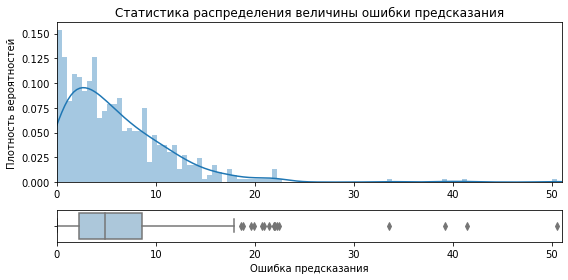

In [61]:
# Подготовка для анализа результатов предсказания тестовой выборки
predict = pd.DataFrame(columns=['pred','Y_test'], index=Y_test.index)
predict['pred']  = pred
predict['Y_test'] = Y_test.values
predict['delta'] = abs(predict['pred'] - predict['Y_test'])
basic_statistics_numerical_features_(
    data=predict['delta'], bins=100, set_lim=[0, 51], 
    title='Статистика распределения величины ошибки предсказания',
    xlabel='Ошибка предсказания', 
)

Обученная модель даёт ошибку предсказания для 97% тестевой выборки не более 18 градуса. Максимальная ошибка достигает 51 градуса, что даёт основания предполагать наличие в тренировочные выборки не выявленных зашумленных наблюдений.

Целевая метрика MAE модели CatBoostRegressor (mae=6.084) на 24% меньше метрики MAE для константной модели DummyRegressor (mae=8), что свидетельствует об адекватности модели. Более разительные результаты можно увидеть по метрике R2 для тестевой выборки 0.452, а для 'глупого регрессора' 0. Выявление того, насколько модель улучшает прогнозы по сравнению с константной моделью даёт представление об эффективности алгоритма и подтверждает его работоспособность. Модель CatBoostRegressor не только заметно превосходит простую константную модель, но и объясняет 45% вариации целевого признака.

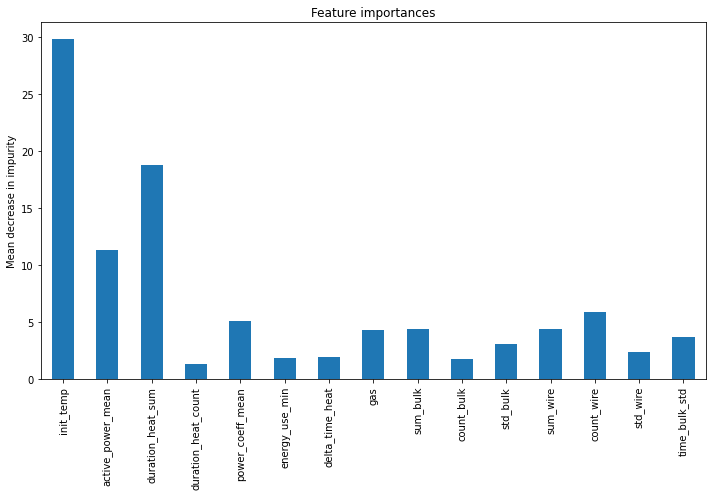

In [62]:
importances = model.feature_importances_
model_importances = pd.Series(importances, index=X_test.columns)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Наиболее значимыми признаками являются 'init_temp', 'duration_heat_sum' и 'active_power_mean' которые по своей сути отражают начальные параметры системы и количество переданной ей энергии, поэтому данные признаки наиболее значимо влияют на прогнозирование конечной температуры, чем выше значения указанных признаков, тем более высокая температура будет прогнозироваться. Остальные признаки, хотя и менее значимы, могут влиять на общую динамику системы. Важно учитывать их в контексте, чтобы получить более точные прогнозы.

## **6. Общие выводы**

1. **Загрузка данных.**

    База данных содержит информацию о семи таблицах, указанных в описании. Размер таблиц колеблется в диапазоне 3081-15907, колонок 2-15. Таблицы data_wire и data_wire_time содержат только 9 колонок, что не соответствует описанию задания, где количество колонок должно быть равно 15.
    
2. **Исследовательский анализ и предобработка данных.**

    - *Данные об электродах 'data_arc'* показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки. Было создано 5 дополнительных признаков:
        - длительность нагрева `'duration_heat'`;
        - полная мощность `'full_power'`;
        - коэффициент мощности `'power_coeff'`;
        - энергопотребление `'energy_use'`;
        - длительность между первым и последним циклом нагрева `'delta_time_heat'`.
        
        А также сгенерированы агрегированные значения признаков: mean, std, min, max, count. Все признаки характеризуются сильной правосторонней или левосторонней асимметрией с наличием большого числа выбросов.
    - *Данные о продувке сплава газом 'data_gas'* характеризуются правосторонней асимметрией с наличием большого числа выбросов.
    - *Данные об изменениях температуры 'data_temp'* показали шести аномальных температуры (ниже 1500 гдад), которые были исправлены на следующее адекватное в ряду. Начальное значение температуры выбрано за признак, конечное значение температуры выбрано в качестве целевого значения. Основное количество циклов нагрева для каждой партии `'duration_heat_count'` находится в диапазоне 4-7 раз (83% наблюдений), при этом наиболее редкими событиями являются 10 и более раз (0.6% наблюдений).
    - *Данные об объёме сыпучих материалов 'data_bulk'* показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки. Признаки характеризуются большим разнообразием частот количества значений 1-2805, в следствии чего можно наблюдать пропуски в диапазоне 99.9-10.4%. Наибольшая частота обработак сыпучими материалами (88% всего количества) происходит на 3, 4, 12, 14 и 15 цикла, что соответствует 94% всего объёма материала. По объёмам используемого материала наиболее частыми можно отметить значения, распределение которых концентрируется вокруг 100, 150, 200, 250, 300 и 400. Основное количество циклов обработки сыпучими материалами для каждой партии `'count_bulk'` находится в диапазоне 4-6 раз (79% наблюдений), при этом наиболее редкими событиями являются 6 и более раз (2.2% наблюдений).
    - *Данные о времени подачи сыпучих материалов 'data_bulk_time'* показали шести аномальных партий, в которых отмечена аномально высокая временная дисперсия подачи материала, выявленные партии были исключены из анализа. Направление движения времени подачи сыпучих материалов идёт в противоположном направлении от обозначенного порядка признаков - данное свойство не описано в задании проекта. Часто в одних и тех же наблюдениях встречаются ряды с одинаковыми значениями времени в разные циклы обработки, данное явление невозможно физически, либо подразумевается некоторое иное технологическое явление, однако указаний на это в описании проекта отсутствует, поэтому эти данные решено оставить. У 14% наблюдений нарушается равномерный порядок изменения значений времени, если исходить из того, что данные о времени даны точные, то случаи, когда нарушается равномерный порядок изменения ряда, может свидетельствовать о переходе технологического процесса на следующие сутки или ошибке внесения данных.
    - *Данные об объёме проволочных материалов 'data_wire'.* Основное количество обработок происходит на первой и второй итерации (95% всего количества и объёма соответственно), в следствии чего основная доля пропусков наблюдается во всех остальных признаках 97.6-99.9%. По объёмам используемого материала наиболее частые значения находятся в диапазоне 0-300 с пиком плотности вероятности на 100. Основное количество циклов добавления легирующих материалов для каждой партии `'count_wire'` находится в диапазоне 2-3 раза (98% наблюдений), при этом наиболее редкими событиями являются 1 и 4 и более раз (0.3% наблюдений)
    - *Данные о времени подачи проволочных материалов 'data_wire_time'* показали наличие одной аномалии, партия, в которой была аномалия, исключена из выборки.
    - Для обучения моделей оставлены признаки с величиной отсечения по коэффициенту корреляции 0.8. В получившемся дата фрейме наибольшая корреляция наблюдается между производными одного признака. Отметим явную обратную корреляцию между начальной температурой и величинами, отражающими затраченную энергию на процесс, что объясняется необходимостью большего подогрева обрабатываемого материала. Такая же обратная зависимость между количеством циклов нагревания и минимальной затраченной энергией на прогрев материала. Сильный коэффициент Фи (0.65) наблюдается между конечной температурой и количеством введения легирующего материала, что видимо, объясняется необходимостью держать относительно высокие температуры при легировании стали и недопущения кристаллизации материала.

3. **Обучение моделей.**
    - В ходе исследования данных было получена 36 признаков, описывающих физический и временные характеристики технологического процесса обработки расплава. В ходе предобработки и подготовки данных было оставлено 15 наиболее перспективных признаков, которые вносят значимый вклад в прогнозирование целевой метрики. 
    - Проверка на безлайновых моделях выявила три наиболее перспективные модели для построения прогнозов, это: Ridge, LinearBoostRegressor и CatBoostRegressor.
    - Анализ значимости признаков показал следующее:
        - Наиболее значимыми признаками являются `'init_temp'`, `'duration_heat_sum'`, `''power_coeff_mean''` и `'active_power_mean'` которые по своей сути отражают начальные параметры системы и количество переданной ей энергии, поэтому данные признаки наиболее значимо влияют на прогнозирование конечной температуры, чем выше значения указанных признаков, тем более высокая температура будет прогнозироваться. Остальные признаки вносят по большей части вспомогательный характер и имеют меньшее влияние на таргет.
        - Признаки `'count_wire'`, `'count_bulk'`, `'time_bulk_std'` и `'delta_time_heat'` временной характер технологических процессов, которые оказывают влияние на целевой признак. Мы видим, что чем меньшее количество операций производится и чем более они короткие, тем более высокие значения целевого признака можно прогнозировать.
        - Признаки `'sum_bulk'`,`'std_bulk'`,`'sum_wire'` и `'std_wire'` характеризует количество дополнительного материала, добавленного в партию. На графиках можно отметить по большей части нелинейные взаимодействия. Скорей всего это связанно не только с изменением объёмов материала и как следствие температурных характеристик. Следует учесть, что эти материалы являются реагентами, и значит могут вступают в реакции как с выделением тепла, так и с поглощением, что невозможно учесть, не зная какой именно материал добавляется в расплав. Так же при добавлении реагентов, происходит выделение газов и шлака. который удаляется и этот факт так же никак не обозначен, хотя по всей видимости будет иметь довольно значимое влияние на конечную температуру сплава.
    - Результаты подбора гиперпараметров для моделей Ridge, LinearBoostRegressor, CatBoostRegressor и 4-ё слойная полносвязная нейронная сеть (FCNN):

        - Ridge - очень быстрая и простая модель, которая даёт приемлемый результат.
        - LinearBoostRegressor - менее точная и медленная модель по сравнению с Ridge.
        - CatBoostRegressor - даёт хорошее и стабильное качество работы с приемлемой скоростью.
        - FCNN - даёт лучшее качество целевой метрики, однако результаты различных итераций обучения модели обладают высокой дисперсией, что в целом делают её близкой по качеству с CatBoostRegressor.

        | Модели регрессии              | MAE   | R2    |
        | ----------------------------- | ----- | ----- |
        | Ridge                         | 6.113 | 0.464 |
        | LinearBoostRegressor          | 6.225 | 0.441 |
        | CatBoostRegressor             | 6.018 | 0.475 |
        | FCNN                          | 5.918 | ----- |
        
    Резюмируя результаты приходим к выводу, что хоть и модель FCNN даёт лучшую метрику на test, различие целевых метрик между test и train показывает, что модель обладает признаками переобучения. В связи с этим выбор падает на CatBoostRegressor, дающий следующий по качеству после FCNN результат.

4. **Тестирование лучшего решения по ML** показало, что целевая метрика MAE модели CatBoostRegressor (mae=6.084) на 24% меньше метрики MAE для константной модели DummyRegressor (mae=8), что свидетельствует об адекватности модели. Более разительные результаты можно увидеть по метрике R2 для тестевой выборки 0.452, а для 'глупого регрессора' 0. Модель CatBoostRegressor не только заметно превосходит простую константную модель, но и объясняет 45% вариации целевого признака. Наиболее значимыми признаками являются 'init_temp', 'duration_heat_sum' и 'active_power_mean' которые по своей сути отражают начальные параметры системы и количество переданной ей энергии, поэтому данные признаки наиболее значимо влияют на прогнозирование конечной температуры, чем выше значения указанных признаков, тем более высокая температура будет прогнозироваться. Остальные признаки, хотя и менее значимы, могут влиять на общую динамику системы. Важно учитывать их в контексте, чтобы получить более точные прогнозы.

4. **Рекомендации.** полученную модель можно значительно улучшить, если попробовать использовать дополнительные данные, не включённые в текущий датасет:
    - Данные о химическом составе стали на разных этапах обработки. Это позволит модели лучше понять влияние легирования на температуру.
    - Данные о состоянии футеровки ковша, что позволит оценить тепло потери, а значит, и на температуру стали.
    - Данные о внешних факторах (температура воздуха, влажность, ветер), что так же поможет промоделировать тепло потери.
    - Данные о характеристики отводимых газов во время продувки, что позволит оценить, как тепло потери, так и особенности физико-химических процессов, происходящих на различных этапах обработки.
    Таким образом созданную модель и результаты интерпретации можно использовать для поиска оптимального графика подачи легирующих и сыпучих материалов, который позволит минимизировать энергопотребление и при этом достигать требуемого химического состава стали. Так же использование модели поможет в прогнозировании времени обработки стали, что позволит оптимизировать планирование производства.